# Initialize Workspace

In [ ]:
!pip install neurokit2
!pip install biosppy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 2.0 MB/s eta 0:00:00


In [ ]:
%matplotlib inline

# Basic Imports
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math
from math import floor
import scipy as scipy
import librosa as lbr
import neurokit2 as nk
import pandas as pd
import plotly.express as px
import itertools
import graphviz
import xgboost as xgb
import gc

# Scikit-Learn and Scipy Modules
import seaborn as sns
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score,ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.feature_selection import RFECV, RFE
from sklearn.metrics import roc_curve, auc, cohen_kappa_score
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor,GradientBoostingRegressor,VotingRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif, chi2
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from functools import reduce


from scipy.signal import savgol_filter,iirnotch,lfilter,butter,savgol_coeffs,freqz,find_peaks,resample,welch,periodogram,resample_poly,decimate
from scipy import signal
from scipy.stats import linregress, pearsonr, chisquare, chi2
from scipy.signal import firwin, kaiser_atten, kaiser_beta, lfilter,detrend

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import datasets, layers, models, optimizers, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,GRU,LSTM,Conv2D,Conv1D,Bidirectional,Reshape
from keras import backend as K

# ECG Modules
import biosppy

sns.set(font_scale=1.3)
sns.set_style("white")

In [ ]:
# Mount Google Drive
from google.colab import drive
#drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# Set Google Drive Path
libpath = '/content/drive/My Drive/HeartFEV1 Project/Signal Processing and Machine Learning Code/'

# Import Custom Helper Modules
sys.path.append(libpath+'libs/')

from SQIs import apply_sqi
from pre_processing import data_normalize, up_sampling_data
from generate_dataset import get_dataset_DHMC, get_spirometry_vals
from feature_extractor import get_hand_features
from utilities import get_per_subject_data, edr_neurokit,get_subj_fev1

In [ ]:
# Useful directories
datapath_dir = '/content/drive/My Drive/HeartFEV1 Project/Data/DHMC_Data/dataset/'
saved_models = '/content/drive/My Drive/HeartFEV1 Project/Signal Processing and Machine Learning Code/saved_models/'

In [ ]:
# Initialize Variables
Fs_ppg = 54
Fs_resp = 20
Fs_ecg = 300
Fs_ppg_up = 60

# Trained model to generate pulse wave from peaks and valleys
model_classifier_ecg_board = tf.keras.models.load_model(saved_models+'221030_210932.h5')

# Model Variables
LIMIT1 = 1.0 # 2.0 # 1.0 # 1.25
LIMIT2 = 1.5 # 2.75 # 1.5 # 1.54
LIMIT3 =  2.0 # 3.0 # 2.00 #2.40

# Make them the ones discovered with your magical numbers.
num_epochs = 5 #
batch_size = 8
lr = 0.0001
loss_fn = 'mse'

In [ ]:
def data_preprocess(ECG_data,RESP_data,PPG_data,fev1_in,fvc_in,bmi_in,subjects_in,fs_resp,fs_ecg,PPG_input=False):
  # Normalize and up-sample PPG
  PPG_data_bw_90 = up_sampling_data(PPG_data.reshape(PPG_data.shape[0],PPG_data.shape[1],1),RESP_data.shape[1]*3)
  PPG_in = data_normalize(PPG_data_bw_90)
  RESP_in = data_normalize(RESP_data.reshape(RESP_data.shape[0],RESP_data.shape[1],1))
  ECG_in = data_normalize(ECG_data.reshape(ECG_data.shape[0],ECG_data.shape[1],1))

  # Apply SQI
  bd_windows = apply_sqi(RESP_in,ECG_in,fs_resp,fs_ecg,PPG_input)

  # Remove bad data
  ECG_dhmc = np.delete(ECG_in,bd_windows,0)
  if PPG_input:
    PPG_dhmc = np.delete(PPG_in,bd_windows,0)
  else:
    PPG_dhmc = PPG_in
  RESP_dhmc = np.delete(RESP_in,bd_windows,0)
  subjects_left_dhmc = np.delete(subjects_in,bd_windows,0)
  fev1_dhmc = np.delete(fev1_in,bd_windows,0)
  fvc_dhmc = np.delete(fvc_in,bd_windows,0)
  bmi_dhmc = np.delete(bmi_in,bd_windows,0)
  return ECG_dhmc,PPG_dhmc,RESP_dhmc,subjects_left_dhmc,fev1_dhmc,fvc_dhmc,bmi_dhmc

In [ ]:
def quantize_fev1_class(nums,lim1 =LIMIT1,lim2=LIMIT2, lim3=LIMIT3):
  classes_out = np.zeros_like(nums)-1000
  for i in range(len(nums)):
    if nums[i] <= lim1:
      classes_out[i] = 0
    elif (nums[i]> lim1) and (nums[i]<=lim2):
      classes_out[i] = 1
    elif (nums[i]> lim2) and (nums[i]<=lim3):
      classes_out[i] = 2
    elif nums[i]>lim3:
      classes_out[i] = 3
    else:
      print('Bloody hell')
  return classes_out

In [ ]:
def get_sample_weights(y_in):
  y_input = quantize_fev1_class(y_in)
  class_wt = compute_class_weight(class_weight='balanced',classes=np.unique(y_input),y=y_input)
  sample_weights = np.zeros((y_in.shape[0],))
  for j in range(y_input.shape[0]):
    if y_input[j]==0:
      sample_weights[j] = class_wt[0]
    elif y_input[j]==1:
      sample_weights[j] = class_wt[1]
    elif y_input[j]==2:
      sample_weights[j] = class_wt[2]
    elif y_input[j]==3:
      sample_weights[j] = class_wt[3]
    else:
      raise SystemError('Unknown class')
  return sample_weights

In [ ]:
def get_dataset(indices_in,x_in,y_in,edr_in,clss_in,subj_in):
  x_test = x_in[indices_in]
  y_test_r = y_in[indices_in]
  y_class = clss_in[indices_in]
  subs = subj_in[indices_in]
  return x_test,y_test_r,y_class,subs

In [ ]:
def get_subj_indices(subjs_wanted,subjects_total):
  return np.argwhere(np.in1d(subjects_total,subjs_wanted))[:,0]

In [ ]:
def visualize_results(y_true,y_predicted,title_in):
  slope_rr, intercept_rr, r_rr, p_val_r, se_rr = linregress(y_true,y_predicted)
  r_sq_rr = r_rr**2
  sns.set(font_scale=1.3)
  sns.set_style("white")
  plt.plot(y_true,y_predicted,'*')
  plt.xlabel('True FEV1')
  plt.ylabel('Predicted FEV1')
  plt.title(title_in+': r = '+str(np.round(r_rr,2))+', R^2 = '+str(np.round(r_sq_rr,2)))
  plt.show()
  return

# Load DHMC Dataset

In [ ]:
ECG_data,RESP_data,_,subjects_dhmc = get_dataset_DHMC()
ECG_data_ppg,RESP_data_ppg,PPG_data,subjects_dhmc_ppg = get_dataset_DHMC(True)

print(ECG_data.shape, RESP_data.shape, len(subjects_dhmc))
print(ECG_data_ppg.shape, RESP_data_ppg.shape,PPG_data.shape,len(subjects_dhmc_ppg))

(148, 27000) (148, 1800) 148
(121, 27000) (121, 1800) (121, 4860) 121


In [ ]:
fev1,fvc,bmi = get_spirometry_vals(subjects_dhmc)
fev1_ppg,fvc_ppg,bmi_ppg = get_spirometry_vals(subjects_dhmc_ppg)
print(fev1.shape,fvc.shape,bmi.shape)
print(fev1_ppg.shape,fvc_ppg.shape,bmi_ppg.shape)

(148,) (148,) (148,)
(121,) (121,) (121,)


# Data Pre-processing

In [ ]:
ECG_dhmc,_,RESP_dhmc,subjects_left_dhmc,fev1_dhmc,fvc_dhmc,bmi_dhmc = data_preprocess(ECG_data,RESP_data,PPG_data,fev1,fvc,bmi,subjects_dhmc,Fs_resp,Fs_ecg,False)
print(len(subjects_left_dhmc),ECG_dhmc.shape,RESP_dhmc.shape,fev1_dhmc.shape,fvc_dhmc.shape,bmi_dhmc.shape,len(np.unique(subjects_left_dhmc)), len(np.unique(subjects_dhmc)))

[  7   8   9  16  22  24  25  26  27  30  33  37  45  52  80  82  85  93
  94  95  96 100 109 118 119 120 121 122 125 139 141]
[  7   8  28  34  35  36  37  38  39  46  52  55  64  77  78  91  92  93
  94  95  96  99 100 106 108 109 134]
100 (100, 27000, 1) (100, 1800, 1) (100,) (100,) (100,) 24 25


# Trained Models - LOSO

In [ ]:
x_test,y_test_r,y_test_fev,y_test_subj = ECG_dhmc,RESP_dhmc,fev1_dhmc,subjects_left_dhmc

print(x_test.shape,y_test_r.shape,y_test_fev.shape,y_test_subj.shape)

(100, 27000, 1) (100, 1800, 1) (100,) (100,)


## FVC Estimator

### Create inputs

In [ ]:
# Initialize EDR signal
x_input = layers.Input(shape=(None,x_test.shape[2]),name='inputs')
# Feature Extractor
cnn1 = layers.Conv1D(8,5,padding='same',strides=3,activation='relu')(x_input)
cnn2 = layers.Conv1D(4,7,padding='same',strides=5,activation='relu')(cnn1)
# Classifier layer 1
clss_1 = layers.Bidirectional(layers.GRU(16,activation='tanh', recurrent_activation='sigmoid',return_sequences=True))(cnn2)
clss_2 = layers.Bidirectional(layers.GRU(8,activation='tanh', recurrent_activation='sigmoid',return_sequences=True))(clss_1)
# Linear regression
dense_reg = layers.Dense(2, activation='swish')(clss_2)
reg_pred = layers.Dense(1, activation='linear',name='regression')(dense_reg)
# Instantiate an end-to-end model predicting both priority and department
model_edr = keras.Model(inputs=[x_input], outputs=[reg_pred])
adam = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model_edr.compile(optimizer=adam, loss={'regression':'mse'})
model_edr.summary()
# Compile the model
model_edr.load_weights(saved_models+'worst_case_240207_200203.hdf5')

Model: "model_134"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None, 1)]         0         
                                                                 
 conv1d_316 (Conv1D)         (None, None, 8)           48        
                                                                 
 conv1d_317 (Conv1D)         (None, None, 4)           228       
                                                                 
 bidirectional_66 (Bidirect  (None, None, 32)          2112      
 ional)                                                          
                                                                 
 bidirectional_67 (Bidirect  (None, None, 16)          2016      
 ional)                                                          
                                                                 
 dense_29 (Dense)            (None, None, 2)           34

In [ ]:
# Model 1
x_input = layers.Input(shape=(None,x_test.shape[2]),name='inputs')
# Feature Extractor
cnn1 = layers.Conv1D(8,5,padding='same',strides=3,activation='relu')(x_input)
cnn2 = layers.Conv1D(4,7,padding='same',strides=5,activation='relu')(cnn1)
model1 = keras.Model(inputs=[x_input], outputs=[cnn2])
adam = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model1.compile(optimizer=adam, loss={'regression':'mse'})
# Initialize EDR Algorithm weights
model1.layers[1].set_weights(model_edr.layers[1].get_weights())
model1.layers[2].set_weights(model_edr.layers[2].get_weights())
model1.layers[1].trainable = False
model1.layers[2].trainable = False
model1.summary()

cnn2_in = model1.predict(x_test)
print(cnn2_in.shape)

Model: "model_135"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None, 1)]         0         
                                                                 
 conv1d_318 (Conv1D)         (None, None, 8)           48        
                                                                 
 conv1d_319 (Conv1D)         (None, None, 4)           228       
                                                                 
Total params: 276 (1.08 KB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 276 (1.08 KB)
_________________________________________________________________
4/4 [==============================] - 0s 26ms/step
(100, 1800, 4)


In [ ]:
# Model 2
x_input = layers.Input(shape=(None,x_test.shape[2]),name='inputs')
# Feature Extractor
cnn1 = layers.Conv1D(8,5,padding='same',strides=3,activation='relu')(x_input)
cnn2 = layers.Conv1D(4,7,padding='same',strides=5,activation='relu')(cnn1)
# Classifier layer 1
clss_1 = layers.Bidirectional(layers.GRU(16,activation='tanh', recurrent_activation='sigmoid',return_sequences=True))(cnn2)
clss_2 = layers.Bidirectional(layers.GRU(8,activation='tanh', recurrent_activation='sigmoid',return_sequences=True))(clss_1)
model2 = keras.Model(inputs=[x_input], outputs=[clss_2])
adam = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model2.compile(optimizer=adam, loss={'regression':'mse'})
# Initialize EDR Algorithm weights
model2.layers[1].set_weights(model_edr.layers[1].get_weights())
model2.layers[2].set_weights(model_edr.layers[2].get_weights())
model2.layers[3].set_weights(model_edr.layers[3].get_weights())
model2.layers[4].set_weights(model_edr.layers[4].get_weights())
model2.layers[1].trainable = False
model2.layers[2].trainable = False
model2.layers[3].trainable = False
model2.layers[4].trainable = False
model2.summary()

clss_2_in = model2.predict(x_test)
print(clss_2_in.shape)

Model: "model_136"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None, 1)]         0         
                                                                 
 conv1d_320 (Conv1D)         (None, None, 8)           48        
                                                                 
 conv1d_321 (Conv1D)         (None, None, 4)           228       
                                                                 
 bidirectional_68 (Bidirect  (None, None, 32)          2112      
 ional)                                                          
                                                                 
 bidirectional_69 (Bidirect  (None, None, 16)          2016      
 ional)                                                          
                                                                 
Total params: 4404 (17.20 KB)
Trainable params: 0 (0.00 B

In [ ]:
reg_pred_in = model_edr.predict(x_test)
print(reg_pred_in.shape)

4/4 [==============================] - 5s 726ms/step
(100, 1800, 1)


In [ ]:
x_test_new = np.concatenate((cnn2_in,clss_2_in,reg_pred_in),axis=2)
print(x_test_new.shape)

(100, 1800, 21)


### Evaluate on trained models

In [ ]:
modelspath = saved_models+'LOSO_FEV1_Models/FVC_Estimator'
print(modelspath)
modelfiles = os.listdir(modelspath)
print(modelfiles)

/content/drive/My Drive/HeartFEV1 Project/Signal Processing and Machine Learning Code/saved_models/LOSO_FEV1_Models/FVC_Estimator
['fvc_n-007_240326_045148.hdf5', 'fvc_c-020_240325_172441.hdf5', 'fvc_c-017_240325_164002.hdf5', 'fvc_c-016_240326_040219.hdf5', 'fvc_c-015_240326_044153.hdf5', 'fvc_c-013_240325_171923.hdf5', 'fvc_c-007_240325_162928.hdf5', 'fvc_c-011_240326_043835.hdf5', 'fvc_c-010_240326_035611.hdf5', 'fvc_c-008_240325_171423.hdf5', 'fvc_c-012_240326_043930.hdf5', 'fvc_c-004_240326_043420.hdf5', 'fvc_c-003_240325_170911.hdf5', 'fvc_c-002_240326_043127.hdf5', 'fvc_n-012_240325_165529.hdf5', 'fvc_n-015_240325_173858.hdf5', 'fvc_n-013_240325_173627.hdf5', 'fvc_n-014_240326_041553.hdf5', 'fvc_n-010_240325_173359.hdf5', 'fvc_n-009_240326_041130.hdf5', 'fvc_n-004_240326_044801.hdf5', 'fvc_n-005_240325_164514.hdf5', 'fvc_n-003_240326_044705.hdf5', 'fvc_n-006_240325_164626.hdf5']


In [ ]:
y_train_fev1_true = []
y_train_fev1_pred = []
y_train_subj_pred = []

y_test_fev1_pred = np.zeros_like(y_test_fev)
subjects_fold = np.unique(y_test_subj)
y_test_fev1_pred_per_subject = np.zeros((len(subjects_fold),2))
m = 0
now = datetime.datetime.now()
date_n = now.strftime("%y%m%d_%H%M%S")
print(date_n)
data_modeled = 'edr_fvc_loso'

240513_172827


In [ ]:
for fold in subjects_fold:
  print('DHMC Subject = ',fold)

  # Create train, val and test data
  idx_test = np.argwhere(y_test_subj==fold)[:,0]
  idx_train = np.argwhere(y_test_subj!=fold)[:,0]
  data_test_x = x_test_new[idx_test]
  data_test_y = y_test_r[idx_test]
  data_test_fev1 = y_test_fev[idx_test]
  data_train_x = x_test_new[idx_train]
  data_train_y = y_test_r[idx_train]
  data_train_fev1 = y_test_fev[idx_train]
  data_train_subjects = y_test_subj[idx_train]

  # Initialize model
  x_input = layers.Input(shape=(data_train_x.shape[1],data_train_x.shape[2]),name='inputs')
  gru_out = layers.Conv1D(10,9,activation='relu',strides=7,padding='same')(x_input)
  batch_out = layers.BatchNormalization()(gru_out)
  gru_out = layers.Conv1D(10,9,activation='relu',strides=7,padding='same')(batch_out)
  batch_out = layers.BatchNormalization()(gru_out)
  pool1 = layers.GlobalAveragePooling1D()(batch_out)
  fev_pred = layers.Dense(1, activation='linear',name='fev1')(pool1)

  model = keras.Model(inputs=[x_input], outputs=[fev_pred])
  adam = tf.keras.optimizers.RMSprop(learning_rate=lr)
  model.compile(optimizer=adam,loss={'fev1':loss_fn},weighted_metrics=[loss_fn])
  # model.summary()

  # Get the LOSO model for this subject
  filepath_possibility = [i for i in modelfiles if fold in i]
  if len(filepath_possibility) != 1:
    raise SystemError('Multiple filepaths detected for subject. Please pick one')

  # Model Performance
  filepath = modelspath+'/'+filepath_possibility[0]
  model.load_weights(filepath)
  model.compile(optimizer=adam, loss={'fev1':loss_fn})
  # Train set performance
  results_train = model.evaluate({'inputs':data_train_x},{'fev1':data_train_fev1},batch_size=batch_size,verbose = 1)
  # print(results_train)
  y_train_pred_fev1 = model.predict(data_train_x)
  y_train_fev1_true.append(data_train_fev1)
  y_train_fev1_pred.append(y_train_pred_fev1[:,0])
  y_train_subj_pred.append(data_train_subjects)
  # Get average subject performance
  y_train_true = get_subj_fev1(data_train_fev1,data_train_subjects)
  y_train_predicted = get_subj_fev1(y_train_pred_fev1[:,0],data_train_subjects)
  # Compute regression
  slope_rr_train, intercept_rr_train, r_rr_train, p_val_r_train, se_rr_train = linregress(y_train_true,y_train_predicted)

  # Test set performance
  results_test = model.evaluate({'inputs':data_test_x},{'fev1':data_test_fev1},batch_size=batch_size,verbose = 1)
  # print(results_test)
  y_test_pred_fev1 = model.predict(data_test_x)
  y_test_fev1_pred[idx_test] = y_test_pred_fev1[:,0]

  del model
  gc.collect()
  m = m+1

DHMC Subject =  c-002
1/1 [==============================] - 0s 22ms/step
DHMC Subject =  c-003
1/1 [==============================] - 0s 26ms/step
DHMC Subject =  c-004
1/1 [==============================] - 0s 30ms/step
DHMC Subject =  c-007
1/1 [==============================] - 0s 31ms/step
DHMC Subject =  c-008
1/1 [==============================] - 0s 42ms/step
DHMC Subject =  c-010
1/1 [==============================] - 0s 26ms/step
DHMC Subject =  c-011
1/1 [==============================] - 0s 24ms/step
DHMC Subject =  c-012
1/1 [==============================] - 0s 113ms/step
DHMC Subject =  c-013
1/1 [==============================] - 0s 24ms/step
DHMC Subject =  c-015
1/1 [==============================] - 0s 25ms/step
DHMC Subject =  c-016
1/1 [==============================] - 0s 55ms/step
DHMC Subject =  c-017
1/1 [==============================] - 0s 43ms/step
DHMC Subject =  c-020
1/1 [==============================] - 0s 128ms/step
DHMC Subject =  n-003
1/1 [=========

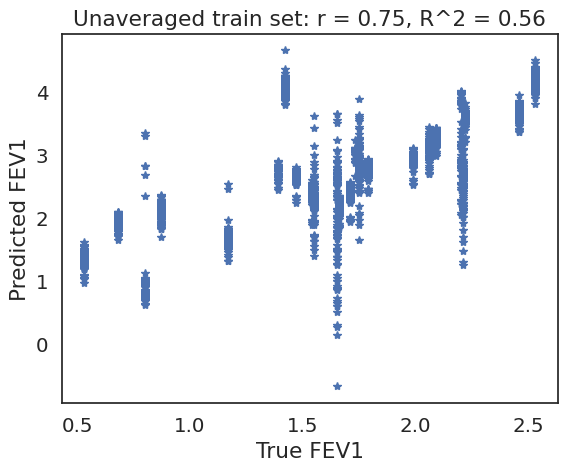

In [ ]:
# Train set performance
y_true = np.concatenate(y_train_fev1_true)
y_predicted = np.concatenate(y_train_fev1_pred)
visualize_results(y_true,y_predicted,'Unaveraged train set')

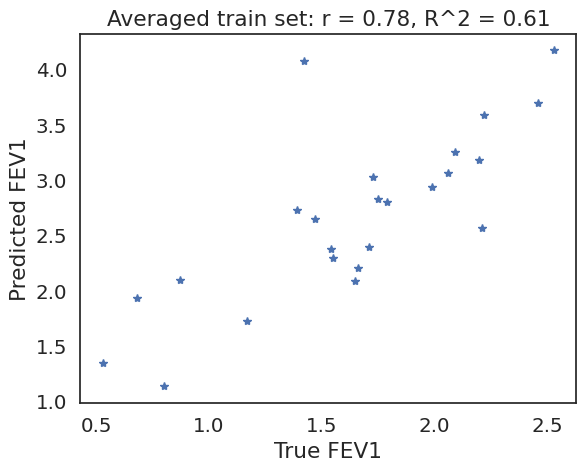

In [ ]:
# Train performance per subject
# Per subject performance
y_true = get_subj_fev1(np.concatenate(y_train_fev1_true),np.concatenate(y_train_subj_pred))
y_predicted = get_subj_fev1(np.concatenate(y_train_fev1_pred),np.concatenate(y_train_subj_pred))
visualize_results(y_true,y_predicted,'Averaged train set')

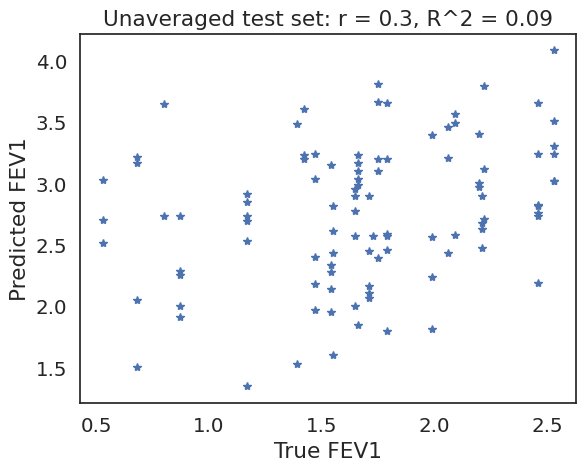

In [ ]:
# Test set performance
y_true = y_test_fev
y_predicted = y_test_fev1_pred
visualize_results(y_true,y_predicted,'Unaveraged test set')

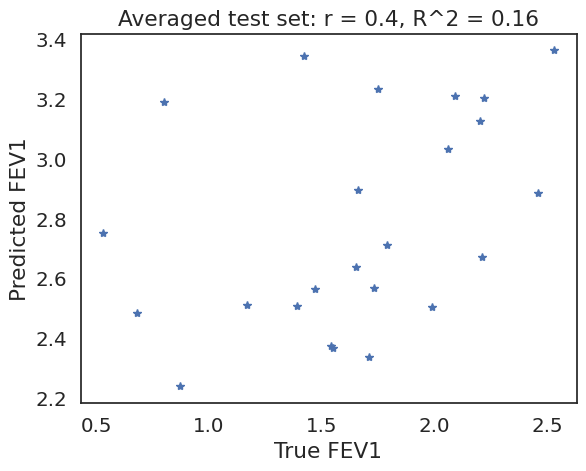

In [ ]:
# Test performance per subject
# Per subject performance
y_true = get_subj_fev1(y_test_fev,y_test_subj) # np.genfromtxt(modelpath+'240129_231621fev1_loso_fold_y_test_predicted.csv',delimiter=',')
y_predicted = get_subj_fev1(y_test_fev1_pred,y_test_subj)

visualize_results(y_true,y_predicted,'Averaged test set')

## FEV1 Estimator

### Create Inputs

In [ ]:
# Initialize EDR signal
x_input = layers.Input(shape=(None,x_test.shape[2]),name='inputs')
# Feature Extractor
cnn1 = layers.Conv1D(8,5,padding='same',strides=3,activation='relu')(x_input)
cnn2 = layers.Conv1D(4,7,padding='same',strides=5,activation='relu')(cnn1)
# Classifier layer 1
clss_1 = layers.Bidirectional(layers.GRU(16,activation='tanh', recurrent_activation='sigmoid',return_sequences=True))(cnn2)
clss_2 = layers.Bidirectional(layers.GRU(8,activation='tanh', recurrent_activation='sigmoid',return_sequences=True))(clss_1)
# Linear regression
dense_reg = layers.Dense(2, activation='swish')(clss_2)
reg_pred = layers.Dense(1, activation='linear',name='regression')(dense_reg)
# Instantiate an end-to-end model predicting both priority and department
model_edr = keras.Model(inputs=[x_input], outputs=[reg_pred])
adam = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model_edr.compile(optimizer=adam, loss={'regression':'mse'})
model_edr.summary()
# Compile the model
model_edr.load_weights(saved_models+'worst_case_240207_200203.hdf5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, None, 8)           48        
                                                                 
 conv1d_1 (Conv1D)           (None, None, 4)           228       
                                                                 
 bidirectional (Bidirection  (None, None, 32)          2112      
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, None, 16)          2016      
 onal)                                                           
                                                                 
 dense (Dense)               (None, None, 2)           34    

In [ ]:
# Model 1
x_input = layers.Input(shape=(None,x_test.shape[2]),name='inputs')
# Feature Extractor
cnn1 = layers.Conv1D(8,5,padding='same',strides=3,activation='relu')(x_input)
cnn2 = layers.Conv1D(4,7,padding='same',strides=5,activation='relu')(cnn1)
model1 = keras.Model(inputs=[x_input], outputs=[cnn2])
adam = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model1.compile(optimizer=adam, loss={'regression':'mse'})
# Initialize EDR Algorithm weights
model1.layers[1].set_weights(model_edr.layers[1].get_weights())
model1.layers[2].set_weights(model_edr.layers[2].get_weights())
model1.layers[1].trainable = False
model1.layers[2].trainable = False
model1.summary()

cnn2_in = model1.predict(x_test)
print(cnn2_in.shape)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None, 1)]         0         
                                                                 
 conv1d_2 (Conv1D)           (None, None, 8)           48        
                                                                 
 conv1d_3 (Conv1D)           (None, None, 4)           228       
                                                                 
Total params: 276 (1.08 KB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 276 (1.08 KB)
_________________________________________________________________
4/4 [==============================] - 1s 60ms/step
(100, 1800, 4)


In [ ]:
# Model 2
x_input = layers.Input(shape=(None,x_test.shape[2]),name='inputs')
# Feature Extractor
cnn1 = layers.Conv1D(8,5,padding='same',strides=3,activation='relu')(x_input)
cnn2 = layers.Conv1D(4,7,padding='same',strides=5,activation='relu')(cnn1)
# Classifier layer 1
clss_1 = layers.Bidirectional(layers.GRU(16,activation='tanh', recurrent_activation='sigmoid',return_sequences=True))(cnn2)
clss_2 = layers.Bidirectional(layers.GRU(8,activation='tanh', recurrent_activation='sigmoid',return_sequences=True))(clss_1)
model2 = keras.Model(inputs=[x_input], outputs=[clss_2])
adam = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model2.compile(optimizer=adam, loss={'regression':'mse'})
# Initialize EDR Algorithm weights
model2.layers[1].set_weights(model_edr.layers[1].get_weights())
model2.layers[2].set_weights(model_edr.layers[2].get_weights())
model2.layers[3].set_weights(model_edr.layers[3].get_weights())
model2.layers[4].set_weights(model_edr.layers[4].get_weights())
model2.layers[1].trainable = False
model2.layers[2].trainable = False
model2.layers[3].trainable = False
model2.layers[4].trainable = False
model2.summary()

clss_2_in = model2.predict(x_test)
print(clss_2_in.shape)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None, 1)]         0         
                                                                 
 conv1d_4 (Conv1D)           (None, None, 8)           48        
                                                                 
 conv1d_5 (Conv1D)           (None, None, 4)           228       
                                                                 
 bidirectional_2 (Bidirecti  (None, None, 32)          2112      
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, None, 16)          2016      
 onal)                                                           
                                                                 
Total params: 4404 (17.20 KB)
Trainable params: 0 (0.00 Byt

In [ ]:
reg_pred_in = model_edr.predict(x_test)
print(reg_pred_in.shape)

4/4 [==============================] - 3s 366ms/step
(100, 1800, 1)


In [ ]:
x_test_new = np.concatenate((cnn2_in,clss_2_in,reg_pred_in),axis=2)
print(x_test_new.shape)

(100, 1800, 21)


### Evaluate on trained models

In [ ]:
modelspath = saved_models+'LOSO_FEV1_Models/FEV1_Estimator'
print(modelspath)
modelfiles = os.listdir(modelspath)
print(modelfiles)

/content/drive/My Drive/HeartFEV1 Project/Signal Processing and Machine Learning Code/saved_models/LOSO_FEV1_Models/FEV1_Estimator
['resp_n-010_240325_235008.hdf5', 'resp_n-009_240322_171958.hdf5', 'resp_n-005_240325_212808.hdf5', 'resp_n-006_240322_171714.hdf5', 'resp_n-007_240325_232943.hdf5', 'resp_n-003_240322_171318.hdf5', 'resp_n-004_240322_171435.hdf5', 'resp_c-016_240325_212134.hdf5', 'resp_c-020_240322_171156.hdf5', 'resp_c-017_240322_171027.hdf5', 'resp_c-015_240322_170737.hdf5', 'resp_c-012_240325_231446.hdf5', 'resp_c-011_240322_173720.hdf5', 'resp_c-013_240322_170612.hdf5', 'resp_c-010_240325_211557.hdf5', 'resp_c-008_240323_235059.hdf5', 'resp_c-002_240322_172852.hdf5', 'resp_c-007_240325_220650.hdf5', 'resp_c-003_240323_232732.hdf5', 'resp_c-004_240325_220547.hdf5', 'resp_n-012_240322_172238.hdf5', 'resp_n-015_240325_213803.hdf5', 'resp_n-014_240325_213651.hdf5', 'resp_n-013_240322_172404.hdf5']


In [ ]:
y_train_fev1_true = []
y_train_fev1_pred = []
y_train_subj_pred = []

y_test_fev1_pred = np.zeros_like(y_test_fev)
subjects_fold = np.unique(y_test_subj)
y_test_fev1_pred_per_subject = np.zeros((len(subjects_fold),2))
m = 0
now = datetime.datetime.now()
date_n = now.strftime("%y%m%d_%H%M%S")
print(date_n)
data_modeled = 'edr_fev1_loso'

240513_164153


In [ ]:
for fold in subjects_fold:
  print('DHMC Subject = ',fold)

  # Create train, val and test data
  idx_test = np.argwhere(y_test_subj==fold)[:,0]
  idx_train = np.argwhere(y_test_subj!=fold)[:,0]
  data_test_x = x_test_new[idx_test]
  data_test_y = y_test_r[idx_test]
  data_test_fev1 = y_test_fev[idx_test]
  data_train_x = x_test_new[idx_train]
  data_train_y = y_test_r[idx_train]
  data_train_fev1 = y_test_fev[idx_train]
  data_train_subjects = y_test_subj[idx_train]

  # Initialize model
  x_input = layers.Input(shape=(data_train_x.shape[1],data_train_x.shape[2]),name='inputs')
  gru_out = layers.Conv1D(10,9,activation='relu',strides=7,padding='same')(x_input)
  batch_out = layers.BatchNormalization()(gru_out)
  gru_out = layers.Conv1D(10,9,activation='relu',strides=7,padding='same')(batch_out)
  batch_out = layers.BatchNormalization()(gru_out)
  pool1 = layers.GlobalAveragePooling1D()(batch_out)
  fev_pred = layers.Dense(1, activation='linear',name='fev1')(pool1)

  model = keras.Model(inputs=[x_input], outputs=[fev_pred])
  adam = tf.keras.optimizers.RMSprop(learning_rate=lr)
  model.compile(optimizer=adam,loss={'fev1':loss_fn},weighted_metrics=[loss_fn])
  # model.summary()

  # Get the LOSO model for this subject
  filepath_possibility = [i for i in modelfiles if fold in i]
  if len(filepath_possibility) != 1:
    raise SystemError('Multiple filepaths detected for subject. Please pick one')

  # Model Performance
  filepath = modelspath+'/'+filepath_possibility[0]
  model.load_weights(filepath)
  model.compile(optimizer=adam, loss={'fev1':loss_fn})

  # Train set performance
  results_train = model.evaluate({'inputs':data_train_x},{'fev1':data_train_fev1},batch_size=batch_size,verbose = 1)
  # print(results_train)
  y_train_pred_fev1 = model.predict(data_train_x)
  y_train_fev1_true.append(data_train_fev1)
  y_train_fev1_pred.append(y_train_pred_fev1[:,0])
  y_train_subj_pred.append(data_train_subjects)

  # Test set performance
  results_test = model.evaluate({'inputs':data_test_x},{'fev1':data_test_fev1},batch_size=batch_size,verbose = 1)
  #print(results_test)
  y_test_pred_fev1 = model.predict(data_test_x)
  y_test_fev1_pred[idx_test] = y_test_pred_fev1[:,0]

  del model
  gc.collect()
  m = m+1

DHMC Subject =  c-002
1/1 [==============================] - 0s 32ms/step
DHMC Subject =  c-003
1/1 [==============================] - 0s 23ms/step
DHMC Subject =  c-004
1/1 [==============================] - 0s 38ms/step
DHMC Subject =  c-007
1/1 [==============================] - 0s 26ms/step
DHMC Subject =  c-008
1/1 [==============================] - 0s 30ms/step
DHMC Subject =  c-010
1/1 [==============================] - 0s 54ms/step
DHMC Subject =  c-011
1/1 [==============================] - 0s 46ms/step
DHMC Subject =  c-012
1/1 [==============================] - 0s 105ms/step
DHMC Subject =  c-013
12/12 [==============================] - 0s 4ms/step - loss: 0.0087


1/1 [==============================] - 0s 28ms/step
DHMC Subject =  c-015
12/12 [==============================] - 0s 3ms/step - loss: 0.0062


1/1 [==============================] - 0s 29ms/step
DHMC Subject =  c-016
1/1 [==============================] - 0s 24ms/step
DHMC Subject =  c-017
1/1 [==============================] - 0s 24ms/step
DHMC Subject =  c-020
1/1 [==============================] - 0s 105ms/step
DHMC Subject =  n-003
1/1 [==============================] - 0s 23ms/step
DHMC Subject =  n-004
1/1 [==============================] - 0s 179ms/step
DHMC Subject =  n-005
1/1 [==============================] - 0s 51ms/step
DHMC Subject =  n-006
1/1 [==============================] - 0s 44ms/step
DHMC Subject =  n-007
1/1 [==============================] - 0s 27ms/step
DHMC Subject =  n-009
1/1 [==============================] - 0s 25ms/step
DHMC Subject =  n-010
1/1 [==============================] - 0s 26ms/step
DHMC Subject =  n-012
1/1 [==============================] - 0s 104ms/step
DHMC Subject =  n-013
1/1 [==============================] - 0s 28ms/step
DHMC Subject =  n-014
1/1 [==============================

### RES

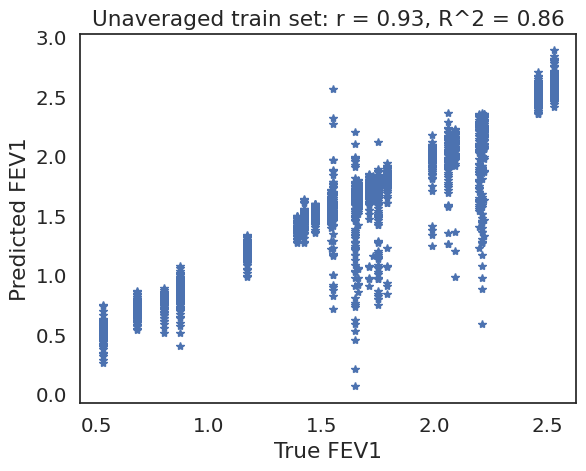

In [ ]:
# Train set performance
y_true = np.concatenate(y_train_fev1_true)
y_predicted = np.concatenate(y_train_fev1_pred)
visualize_results(y_true,y_predicted,'Unaveraged train set')

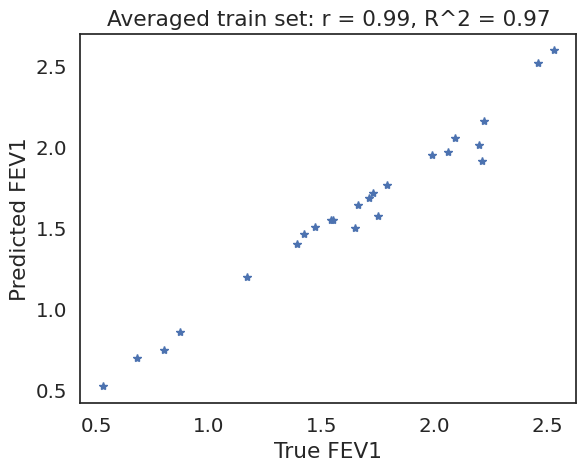

In [ ]:
# Train performance per subject
# Per subject performance
y_true = get_subj_fev1(np.concatenate(y_train_fev1_true),np.concatenate(y_train_subj_pred))
y_predicted = get_subj_fev1(np.concatenate(y_train_fev1_pred),np.concatenate(y_train_subj_pred))
visualize_results(y_true,y_predicted,'Averaged train set')

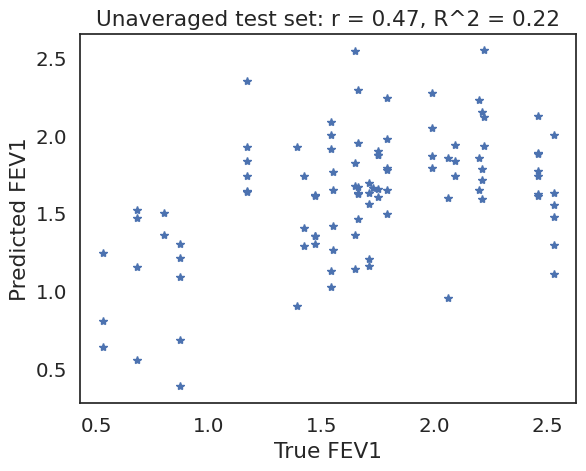

In [ ]:
# Test set performance
y_true = y_test_fev
y_predicted = y_test_fev1_pred
visualize_results(y_true,y_predicted,'Unaveraged test set')

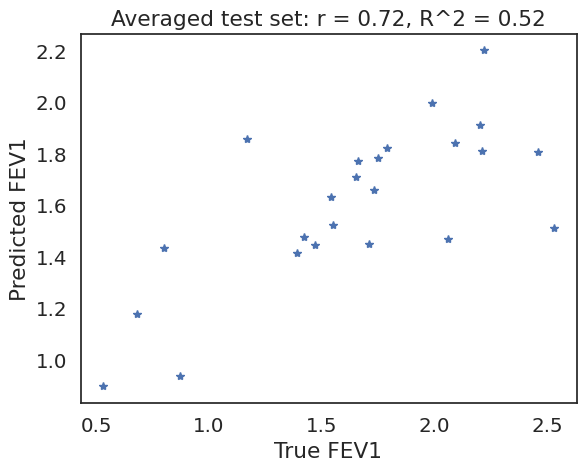

In [ ]:
# Test performance per subject
# Per subject performance
y_true = get_subj_fev1(y_test_fev,y_test_subj) # np.genfromtxt(modelpath+'240129_231621fev1_loso_fold_y_test_predicted.csv',delimiter=',')
y_predicted = get_subj_fev1(y_test_fev1_pred,y_test_subj)

visualize_results(y_true,y_predicted,'Averaged test set')

## FEV1 Estimator ex12

### Create inputs

In [ ]:
# Initialize EDR signal
x_input = layers.Input(shape=(None,x_test.shape[2]),name='inputs')
# Feature Extractor
cnn1 = layers.Conv1D(8,5,padding='same',strides=3,activation='relu')(x_input)
cnn2 = layers.Conv1D(4,7,padding='same',strides=5,activation='relu')(cnn1)
# Classifier layer 1
clss_1 = layers.Bidirectional(layers.GRU(16,activation='tanh', recurrent_activation='sigmoid',return_sequences=True))(cnn2)
clss_2 = layers.Bidirectional(layers.GRU(8,activation='tanh', recurrent_activation='sigmoid',return_sequences=True))(clss_1)
# Linear regression
dense_reg = layers.Dense(2, activation='swish')(clss_2)
reg_pred = layers.Dense(1, activation='linear',name='regression')(dense_reg)
# Instantiate an end-to-end model predicting both priority and department
model_edr = keras.Model(inputs=[x_input], outputs=[reg_pred])
adam = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model_edr.compile(optimizer=adam, loss={'regression':'mse'})
model_edr.summary()
# Compile the model
model_edr.load_weights(saved_models+'worst_case_240207_200203.hdf5')

Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None, 1)]         0         
                                                                 
 conv1d_56 (Conv1D)          (None, None, 8)           48        
                                                                 
 conv1d_57 (Conv1D)          (None, None, 4)           228       
                                                                 
 bidirectional_6 (Bidirecti  (None, None, 32)          2112      
 onal)                                                           
                                                                 
 bidirectional_7 (Bidirecti  (None, None, 16)          2016      
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, None, 2)           34 

In [ ]:
# Model 1
x_input = layers.Input(shape=(None,x_test.shape[2]),name='inputs')
# Feature Extractor
cnn1 = layers.Conv1D(8,5,padding='same',strides=3,activation='relu')(x_input)
cnn2 = layers.Conv1D(4,7,padding='same',strides=5,activation='relu')(cnn1)
model1 = keras.Model(inputs=[x_input], outputs=[cnn2])
adam = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model1.compile(optimizer=adam, loss={'regression':'mse'})
# Initialize EDR Algorithm weights
model1.layers[1].set_weights(model_edr.layers[1].get_weights())
model1.layers[2].set_weights(model_edr.layers[2].get_weights())
model1.layers[1].trainable = False
model1.layers[2].trainable = False
model1.summary()

cnn2_in = model1.predict(x_test)
print(cnn2_in.shape)

Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None, 1)]         0         
                                                                 
 conv1d_58 (Conv1D)          (None, None, 8)           48        
                                                                 
 conv1d_59 (Conv1D)          (None, None, 4)           228       
                                                                 
Total params: 276 (1.08 KB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 276 (1.08 KB)
_________________________________________________________________
4/4 [==============================] - 0s 29ms/step
(100, 1800, 4)


In [ ]:
# Model 2
x_input = layers.Input(shape=(None,x_test.shape[2]),name='inputs')
# Feature Extractor
cnn1 = layers.Conv1D(8,5,padding='same',strides=3,activation='relu')(x_input)
cnn2 = layers.Conv1D(4,7,padding='same',strides=5,activation='relu')(cnn1)
# Classifier layer 1
clss_1 = layers.Bidirectional(layers.GRU(16,activation='tanh', recurrent_activation='sigmoid',return_sequences=True))(cnn2)
clss_2 = layers.Bidirectional(layers.GRU(8,activation='tanh', recurrent_activation='sigmoid',return_sequences=True))(clss_1)
model2 = keras.Model(inputs=[x_input], outputs=[clss_2])
adam = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model2.compile(optimizer=adam, loss={'regression':'mse'})
# Initialize EDR Algorithm weights
model2.layers[1].set_weights(model_edr.layers[1].get_weights())
model2.layers[2].set_weights(model_edr.layers[2].get_weights())
model2.layers[3].set_weights(model_edr.layers[3].get_weights())
model2.layers[4].set_weights(model_edr.layers[4].get_weights())
model2.layers[1].trainable = False
model2.layers[2].trainable = False
model2.layers[3].trainable = False
model2.layers[4].trainable = False
model2.summary()

clss_2_in = model2.predict(x_test)
print(clss_2_in.shape)

Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None, 1)]         0         
                                                                 
 conv1d_60 (Conv1D)          (None, None, 8)           48        
                                                                 
 conv1d_61 (Conv1D)          (None, None, 4)           228       
                                                                 
 bidirectional_8 (Bidirecti  (None, None, 32)          2112      
 onal)                                                           
                                                                 
 bidirectional_9 (Bidirecti  (None, None, 16)          2016      
 onal)                                                           
                                                                 
Total params: 4404 (17.20 KB)
Trainable params: 0 (0.00 By

In [ ]:
reg_pred_in = model_edr.predict(x_test)
print(reg_pred_in.shape)

4/4 [==============================] - 5s 596ms/step
(100, 1800, 1)


In [ ]:
x_test_new = reg_pred_in # np.concatenate((clss_2_in,reg_pred_in),axis=2)
print(x_test_new.shape)

(100, 1800, 1)


### Evaluate on trained models

In [ ]:
modelspath = saved_models+'LOSO_FEV1_Models/FEV1_Estimator_sub12'
print(modelspath)
modelfiles = os.listdir(modelspath)
print(modelfiles)

/content/drive/My Drive/HeartFEV1 Project/Signal Processing and Machine Learning Code/saved_models/LOSO_FEV1_Models/FEV1_Estimator_sub12
['resp_c-017_240324_201401.hdf5', 'resp_c-016_240324_201303.hdf5', 'resp_c-013_240324_201039.hdf5', 'resp_c-010_240324_200652.hdf5', 'resp_c-011_240324_200818.hdf5', 'resp_c-012_240324_200914.hdf5', 'resp_c-015_240324_201136.hdf5', 'resp_c-008_240324_200526.hdf5', 'resp_c-004_240324_200306.hdf5', 'resp_c-007_240324_200431.hdf5', 'resp_c-003_240324_200140.hdf5', 'resp_c-002_240324_200014.hdf5', 'resp_n-014_240324_202737.hdf5', 'resp_n-015_240324_202902.hdf5', 'resp_n-013_240324_202637.hdf5', 'resp_n-012_240324_202511.hdf5', 'resp_n-004_240324_201751.hdf5', 'resp_n-010_240324_202345.hdf5', 'resp_n-005_240324_201852.hdf5', 'resp_n-006_240324_201951.hdf5', 'resp_n-007_240324_202117.hdf5', 'resp_n-009_240324_202243.hdf5', 'resp_c-020_240324_201500.hdf5', 'resp_n-003_240324_201626.hdf5']


In [ ]:
y_train_fev1_true = []
y_train_fev1_pred = []
y_train_subj_pred = []

y_test_fev1_pred = np.zeros_like(y_test_fev)
subjects_fold = np.unique(y_test_subj)
y_test_fev1_pred_per_subject = np.zeros((len(subjects_fold),2))
m = 0
now = datetime.datetime.now()
date_n = now.strftime("%y%m%d_%H%M%S")
print(date_n)
data_modeled = 'edr_fev1_loso'

240513_165809


In [ ]:
for fold in subjects_fold:
  print('DHMC Subject = ',fold)

  # Create train, val and test data
  idx_test = np.argwhere(y_test_subj==fold)[:,0]
  idx_train = np.argwhere(y_test_subj!=fold)[:,0]
  data_test_x = x_test_new[idx_test]
  data_test_y = y_test_r[idx_test]
  data_test_fev1 = y_test_fev[idx_test]
  data_train_x = x_test_new[idx_train]
  data_train_y = y_test_r[idx_train]
  data_train_fev1 = y_test_fev[idx_train]
  data_train_subjects = y_test_subj[idx_train]

  # Initialize model
  x_input = layers.Input(shape=(data_train_x.shape[1],data_train_x.shape[2]),name='inputs')
  gru_out = layers.Conv1D(10,9,activation='relu',strides=7,padding='same')(x_input)
  batch_out = layers.BatchNormalization()(gru_out)
  gru_out = layers.Conv1D(10,9,activation='relu',strides=7,padding='same')(batch_out)
  batch_out = layers.BatchNormalization()(gru_out)
  pool1 = layers.GlobalAveragePooling1D()(batch_out)
  fev_pred = layers.Dense(1, activation='linear',name='fev1')(pool1)

  model = keras.Model(inputs=[x_input], outputs=[fev_pred])
  adam = tf.keras.optimizers.RMSprop(learning_rate=lr)
  model.compile(optimizer=adam,loss={'fev1':loss_fn},weighted_metrics=[loss_fn])
  #model.summary()

  # Get the LOSO model for this subject
  filepath_possibility = [i for i in modelfiles if fold in i]
  if len(filepath_possibility) != 1:
    raise SystemError('Multiple filepaths detected for subject. Please pick one')

  # Model Performance
  filepath = modelspath+'/'+filepath_possibility[0]
  model.load_weights(filepath)
  model.compile(optimizer=adam, loss={'fev1':loss_fn})
  # Train set performance
  results_train = model.evaluate({'inputs':data_train_x},{'fev1':data_train_fev1},batch_size=batch_size,verbose = 1)
  #print(results_train)
  y_train_pred_fev1 = model.predict(data_train_x)
  y_train_fev1_true.append(data_train_fev1)
  y_train_fev1_pred.append(y_train_pred_fev1[:,0])
  y_train_subj_pred.append(data_train_subjects)
  # Get average subject performance
  y_train_true = get_subj_fev1(data_train_fev1,data_train_subjects)
  y_train_predicted = get_subj_fev1(y_train_pred_fev1[:,0],data_train_subjects)
  # Compute regression
  slope_rr_train, intercept_rr_train, r_rr_train, p_val_r_train, se_rr_train = linregress(y_train_true,y_train_predicted)

  # Test set performance
  results_test = model.evaluate({'inputs':data_test_x},{'fev1':data_test_fev1},batch_size=batch_size,verbose = 1)
  #print(results_test)
  y_test_pred_fev1 = model.predict(data_test_x)
  y_test_fev1_pred[idx_test] = y_test_pred_fev1[:,0]

  del model
  gc.collect()
  m = m+1

DHMC Subject =  c-002
1/1 [==============================] - 0s 60ms/step
DHMC Subject =  c-003
1/1 [==============================] - 0s 27ms/step
DHMC Subject =  c-004
1/1 [==============================] - 0s 37ms/step
DHMC Subject =  c-007
1/1 [==============================] - 0s 54ms/step
DHMC Subject =  c-008
1/1 [==============================] - 0s 38ms/step
DHMC Subject =  c-010
1/1 [==============================] - 0s 22ms/step
DHMC Subject =  c-011
1/1 [==============================] - 0s 25ms/step
DHMC Subject =  c-012
1/1 [==============================] - 0s 103ms/step
DHMC Subject =  c-013
1/1 [==============================] - 0s 24ms/step
DHMC Subject =  c-015
1/1 [==============================] - 0s 26ms/step
DHMC Subject =  c-016
1/1 [==============================] - 0s 36ms/step
DHMC Subject =  c-017
1/1 [==============================] - 0s 37ms/step
DHMC Subject =  c-020
1/1 [==============================] - 0s 114ms/step
DHMC Subject =  n-003
1/1 [=========

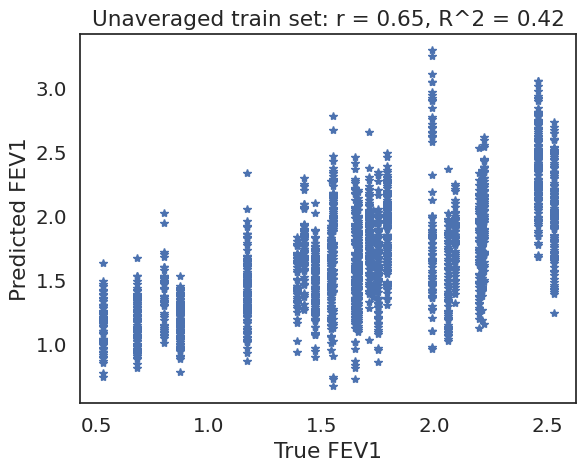

In [ ]:
# Train set performance
y_true = np.concatenate(y_train_fev1_true)
y_predicted = np.concatenate(y_train_fev1_pred)
visualize_results(y_true,y_predicted,'Unaveraged train set')

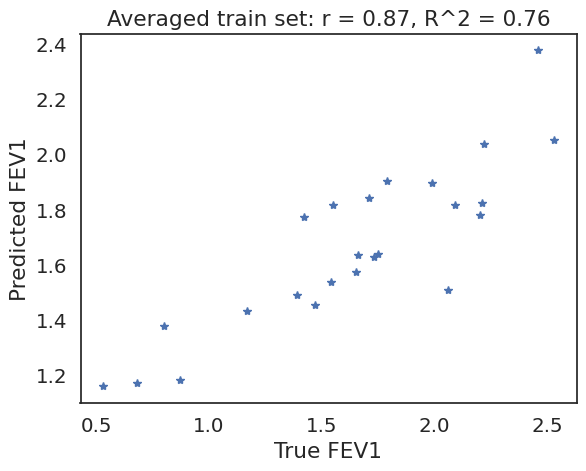

In [ ]:
# Train performance per subject
# Per subject performance
y_true = get_subj_fev1(np.concatenate(y_train_fev1_true),np.concatenate(y_train_subj_pred))
y_predicted = get_subj_fev1(np.concatenate(y_train_fev1_pred),np.concatenate(y_train_subj_pred))
visualize_results(y_true,y_predicted,'Averaged train set')

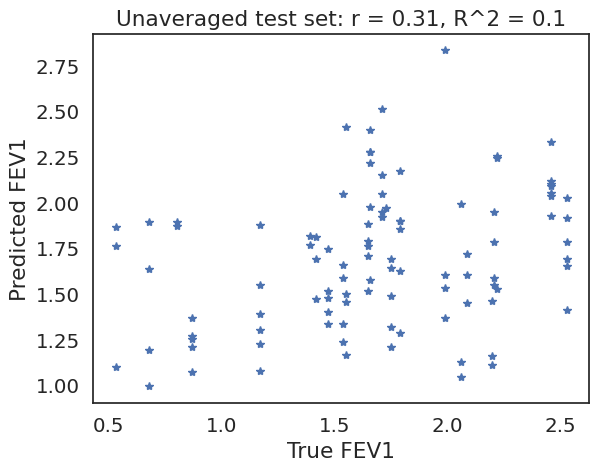

In [ ]:
# Test set performance
y_true = y_test_fev
y_predicted = y_test_fev1_pred
visualize_results(y_true,y_predicted,'Unaveraged test set')

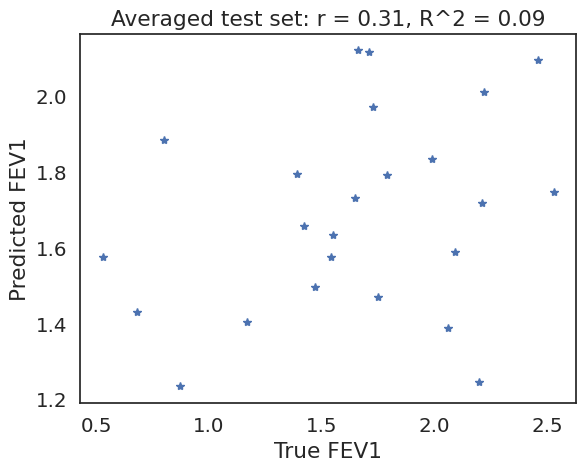

In [ ]:
# Test performance per subject
# Per subject performance
y_true = get_subj_fev1(y_test_fev,y_test_subj) # np.genfromtxt(modelpath+'240129_231621fev1_loso_fold_y_test_predicted.csv',delimiter=',')
y_predicted = get_subj_fev1(y_test_fev1_pred,y_test_subj)

visualize_results(y_true,y_predicted,'Averaged test set')

## FEV1 Estimator ex2

### Create inputs

In [ ]:
# Initialize EDR signal
x_input = layers.Input(shape=(None,x_test.shape[2]),name='inputs')
# Feature Extractor
cnn1 = layers.Conv1D(8,5,padding='same',strides=3,activation='relu')(x_input)
cnn2 = layers.Conv1D(4,7,padding='same',strides=5,activation='relu')(cnn1)
# Classifier layer 1
clss_1 = layers.Bidirectional(layers.GRU(16,activation='tanh', recurrent_activation='sigmoid',return_sequences=True))(cnn2)
clss_2 = layers.Bidirectional(layers.GRU(8,activation='tanh', recurrent_activation='sigmoid',return_sequences=True))(clss_1)
# Linear regression
dense_reg = layers.Dense(2, activation='swish')(clss_2)
reg_pred = layers.Dense(1, activation='linear',name='regression')(dense_reg)
# Instantiate an end-to-end model predicting both priority and department
model_edr = keras.Model(inputs=[x_input], outputs=[reg_pred])
adam = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model_edr.compile(optimizer=adam, loss={'regression':'mse'})
model_edr.summary()
# Compile the model
model_edr.load_weights(saved_models+'worst_case_240207_200203.hdf5')

Model: "model_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None, 1)]         0         
                                                                 
 conv1d_112 (Conv1D)         (None, None, 8)           48        
                                                                 
 conv1d_113 (Conv1D)         (None, None, 4)           228       
                                                                 
 bidirectional_10 (Bidirect  (None, None, 32)          2112      
 ional)                                                          
                                                                 
 bidirectional_11 (Bidirect  (None, None, 16)          2016      
 ional)                                                          
                                                                 
 dense_3 (Dense)             (None, None, 2)           34 

In [ ]:
# Model 1
x_input = layers.Input(shape=(None,x_test.shape[2]),name='inputs')
# Feature Extractor
cnn1 = layers.Conv1D(8,5,padding='same',strides=3,activation='relu')(x_input)
cnn2 = layers.Conv1D(4,7,padding='same',strides=5,activation='relu')(cnn1)
model1 = keras.Model(inputs=[x_input], outputs=[cnn2])
adam = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model1.compile(optimizer=adam, loss={'regression':'mse'})
# Initialize EDR Algorithm weights
model1.layers[1].set_weights(model_edr.layers[1].get_weights())
model1.layers[2].set_weights(model_edr.layers[2].get_weights())
model1.layers[1].trainable = False
model1.layers[2].trainable = False
model1.summary()

cnn2_in = model1.predict(x_test)
print(cnn2_in.shape)

Model: "model_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None, 1)]         0         
                                                                 
 conv1d_114 (Conv1D)         (None, None, 8)           48        
                                                                 
 conv1d_115 (Conv1D)         (None, None, 4)           228       
                                                                 
Total params: 276 (1.08 KB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 276 (1.08 KB)
_________________________________________________________________
4/4 [==============================] - 0s 22ms/step
(100, 1800, 4)


In [ ]:
# Model 2
x_input = layers.Input(shape=(None,x_test.shape[2]),name='inputs')
# Feature Extractor
cnn1 = layers.Conv1D(8,5,padding='same',strides=3,activation='relu')(x_input)
cnn2 = layers.Conv1D(4,7,padding='same',strides=5,activation='relu')(cnn1)
# Classifier layer 1
clss_1 = layers.Bidirectional(layers.GRU(16,activation='tanh', recurrent_activation='sigmoid',return_sequences=True))(cnn2)
clss_2 = layers.Bidirectional(layers.GRU(8,activation='tanh', recurrent_activation='sigmoid',return_sequences=True))(clss_1)
model2 = keras.Model(inputs=[x_input], outputs=[clss_2])
adam = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model2.compile(optimizer=adam, loss={'regression':'mse'})
# Initialize EDR Algorithm weights
model2.layers[1].set_weights(model_edr.layers[1].get_weights())
model2.layers[2].set_weights(model_edr.layers[2].get_weights())
model2.layers[3].set_weights(model_edr.layers[3].get_weights())
model2.layers[4].set_weights(model_edr.layers[4].get_weights())
model2.layers[1].trainable = False
model2.layers[2].trainable = False
model2.layers[3].trainable = False
model2.layers[4].trainable = False
model2.summary()

clss_2_in = model2.predict(x_test)
print(clss_2_in.shape)

Model: "model_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None, 1)]         0         
                                                                 
 conv1d_116 (Conv1D)         (None, None, 8)           48        
                                                                 
 conv1d_117 (Conv1D)         (None, None, 4)           228       
                                                                 
 bidirectional_12 (Bidirect  (None, None, 32)          2112      
 ional)                                                          
                                                                 
 bidirectional_13 (Bidirect  (None, None, 16)          2016      
 ional)                                                          
                                                                 
Total params: 4404 (17.20 KB)
Trainable params: 0 (0.00 By

In [ ]:
reg_pred_in = model_edr.predict(x_test)
print(reg_pred_in.shape)

4/4 [==============================] - 7s 783ms/step
(100, 1800, 1)


In [ ]:
x_test_new = np.concatenate((cnn2_in,reg_pred_in),axis=2)
print(x_test_new.shape)

(100, 1800, 5)


### Evaluate on trained models

In [ ]:
modelspath = saved_models+'LOSO_FEV1_Models/FEV1_Estimator_sub2'
print(modelspath)
modelfiles = os.listdir(modelspath)
print(modelfiles)

/content/drive/My Drive/HeartFEV1 Project/Signal Processing and Machine Learning Code/saved_models/LOSO_FEV1_Models/FEV1_Estimator_sub2
['resp_n-010_240326_011836.hdf5', 'resp_n-007_240325_144702.hdf5', 'resp_n-006_240325_144537.hdf5', 'resp_n-003_240326_011134.hdf5', 'resp_c-017_240326_001312.hdf5', 'resp_c-020_240326_011038.hdf5', 'resp_n-004_240325_144247.hdf5', 'resp_n-005_240326_001807.hdf5', 'resp_c-015_240326_001019.hdf5', 'resp_c-013_240322_191003.hdf5', 'resp_c-016_240326_001145.hdf5', 'resp_c-012_240326_010524.hdf5', 'resp_c-008_240325_143104.hdf5', 'resp_c-004_240326_010019.hdf5', 'resp_c-010_240325_143159.hdf5', 'resp_c-007_240322_190501.hdf5', 'resp_c-003_240326_005912.hdf5', 'resp_c-011_240322_190818.hdf5', 'resp_c-002_240325_142704.hdf5', 'resp_n-014_240326_012228.hdf5', 'resp_n-015_240326_002836.hdf5', 'resp_n-013_240326_002544.hdf5', 'resp_n-012_240326_002417.hdf5', 'resp_n-009_240326_002132.hdf5']


In [ ]:
y_train_fev1_true = []
y_train_fev1_pred = []
y_train_subj_pred = []

y_test_fev1_pred = np.zeros_like(y_test_fev)
subjects_fold = np.unique(y_test_subj)
y_test_fev1_pred_per_subject = np.zeros((len(subjects_fold),2))
m = 0
now = datetime.datetime.now()
date_n = now.strftime("%y%m%d_%H%M%S")
print(date_n)
data_modeled = 'edr_fev1_loso'

240513_170835


In [ ]:
for fold in subjects_fold:
  print('DHMC Subject = ',fold)

  # Create train, val and test data
  idx_test = np.argwhere(y_test_subj==fold)[:,0]
  idx_train = np.argwhere(y_test_subj!=fold)[:,0]
  data_test_x = x_test_new[idx_test]
  data_test_y = y_test_r[idx_test]
  data_test_fev1 = y_test_fev[idx_test]
  data_train_x = x_test_new[idx_train]
  data_train_y = y_test_r[idx_train]
  data_train_fev1 = y_test_fev[idx_train]
  data_train_subjects = y_test_subj[idx_train]

  # Initialize model
  x_input = layers.Input(shape=(data_train_x.shape[1],data_train_x.shape[2]),name='inputs')
  gru_out = layers.Conv1D(10,9,activation='relu',strides=7,padding='same')(x_input)
  batch_out = layers.BatchNormalization()(gru_out)
  gru_out = layers.Conv1D(10,9,activation='relu',strides=7,padding='same')(batch_out)
  batch_out = layers.BatchNormalization()(gru_out)
  pool1 = layers.GlobalAveragePooling1D()(batch_out)
  fev_pred = layers.Dense(1, activation='linear',name='fev1')(pool1)

  model = keras.Model(inputs=[x_input], outputs=[fev_pred])
  adam = tf.keras.optimizers.RMSprop(learning_rate=lr)
  model.compile(optimizer=adam,loss={'fev1':loss_fn},weighted_metrics=[loss_fn])
  # model.summary()

  # Get the LOSO model for this subject
  filepath_possibility = [i for i in modelfiles if fold in i]
  if len(filepath_possibility) == 0:
    raise SystemError('Missing model file')
  elif len(filepath_possibility) > 1:
    raise SystemError('Multiple model files detected for subject. Please pick one')

  # Model Performance
  filepath = modelspath+'/'+filepath_possibility[0]
  model.load_weights(filepath)
  model.compile(optimizer=adam, loss={'fev1':loss_fn})
  # Train set performance
  results_train = model.evaluate({'inputs':data_train_x},{'fev1':data_train_fev1},batch_size=batch_size,verbose = 1)
  # print(results_train)
  y_train_pred_fev1 = model.predict(data_train_x)
  y_train_fev1_true.append(data_train_fev1)
  y_train_fev1_pred.append(y_train_pred_fev1[:,0])
  y_train_subj_pred.append(data_train_subjects)
  # Get average subject performance
  y_train_true = get_subj_fev1(data_train_fev1,data_train_subjects)
  y_train_predicted = get_subj_fev1(y_train_pred_fev1[:,0],data_train_subjects)
  # Compute regression
  slope_rr_train, intercept_rr_train, r_rr_train, p_val_r_train, se_rr_train = linregress(y_train_true,y_train_predicted)

  # Test set performance
  results_test = model.evaluate({'inputs':data_test_x},{'fev1':data_test_fev1},batch_size=batch_size,verbose = 1)
  #print(results_test)
  y_test_pred_fev1 = model.predict(data_test_x)
  y_test_fev1_pred[idx_test] = y_test_pred_fev1[:,0]

  del model
  gc.collect()
  m = m+1

DHMC Subject =  c-002
1/1 [==============================] - 0s 23ms/step
DHMC Subject =  c-003
1/1 [==============================] - 0s 30ms/step
DHMC Subject =  c-004
1/1 [==============================] - 0s 26ms/step
DHMC Subject =  c-007
1/1 [==============================] - 0s 29ms/step
DHMC Subject =  c-008
1/1 [==============================] - 0s 42ms/step
DHMC Subject =  c-010
1/1 [==============================] - 0s 40ms/step
DHMC Subject =  c-011
1/1 [==============================] - 0s 77ms/step
DHMC Subject =  c-012
1/1 [==============================] - 0s 447ms/step
DHMC Subject =  c-013
1/1 [==============================] - 0s 27ms/step
DHMC Subject =  c-015
1/1 [==============================] - 0s 27ms/step
DHMC Subject =  c-016
1/1 [==============================] - 0s 22ms/step
DHMC Subject =  c-017
1/1 [==============================] - 0s 27ms/step
DHMC Subject =  c-020
1/1 [==============================] - 0s 119ms/step
DHMC Subject =  n-003
1/1 [=========

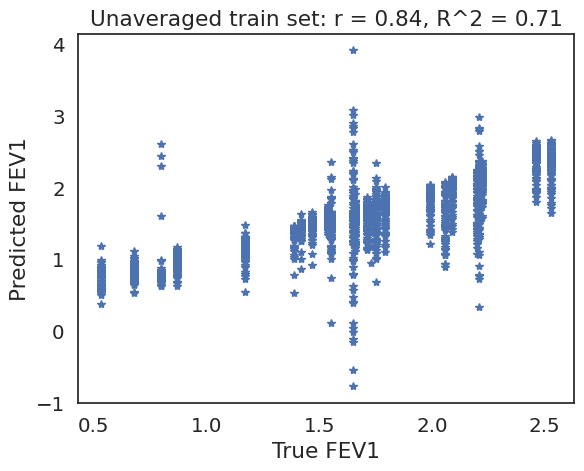

In [ ]:
# Train set performance
y_true = np.concatenate(y_train_fev1_true)
y_predicted = np.concatenate(y_train_fev1_pred)
visualize_results(y_true,y_predicted,'Unaveraged train set')

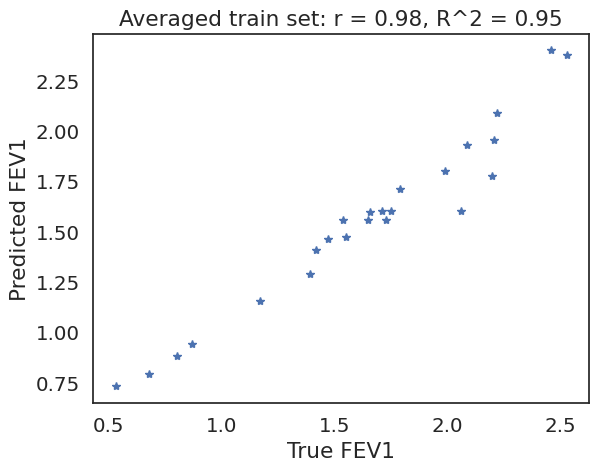

In [ ]:
# Train performance per subject
# Per subject performance
y_true = get_subj_fev1(np.concatenate(y_train_fev1_true),np.concatenate(y_train_subj_pred))
y_predicted = get_subj_fev1(np.concatenate(y_train_fev1_pred),np.concatenate(y_train_subj_pred))
visualize_results(y_true,y_predicted,'Averaged train set')

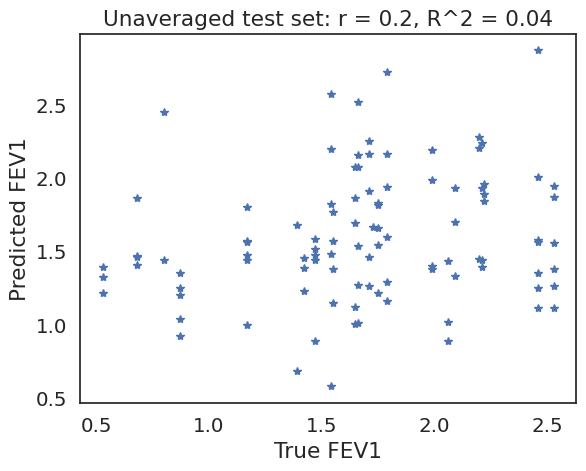

In [ ]:
# Test set performance
y_true = y_test_fev
y_predicted = y_test_fev1_pred
visualize_results(y_true,y_predicted,'Unaveraged test set')

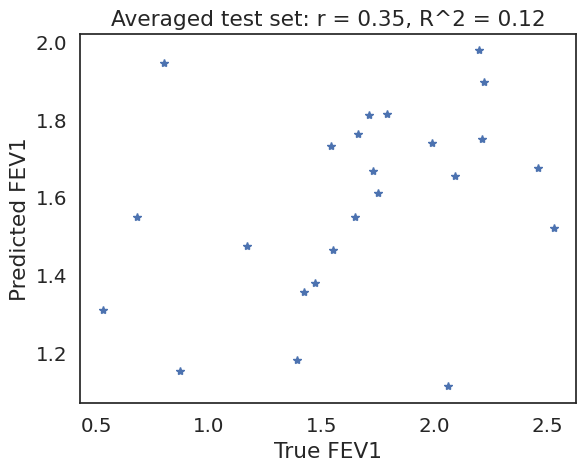

In [ ]:
# Test performance per subject
# Per subject performance
y_true = get_subj_fev1(y_test_fev,y_test_subj) # np.genfromtxt(modelpath+'240129_231621fev1_loso_fold_y_test_predicted.csv',delimiter=',')
y_predicted = get_subj_fev1(y_test_fev1_pred,y_test_subj)

visualize_results(y_true,y_predicted,'Averaged test set')

## FEV1 Estimator ex1

### Create inputs

In [ ]:
# Initialize EDR signal
x_input = layers.Input(shape=(None,x_test.shape[2]),name='inputs')
# Feature Extractor
cnn1 = layers.Conv1D(8,5,padding='same',strides=3,activation='relu')(x_input)
cnn2 = layers.Conv1D(4,7,padding='same',strides=5,activation='relu')(cnn1)
# Classifier layer 1
clss_1 = layers.Bidirectional(layers.GRU(16,activation='tanh', recurrent_activation='sigmoid',return_sequences=True))(cnn2)
clss_2 = layers.Bidirectional(layers.GRU(8,activation='tanh', recurrent_activation='sigmoid',return_sequences=True))(clss_1)
# Linear regression
dense_reg = layers.Dense(2, activation='swish')(clss_2)
reg_pred = layers.Dense(1, activation='linear',name='regression')(dense_reg)
# Instantiate an end-to-end model predicting both priority and department
model_edr = keras.Model(inputs=[x_input], outputs=[reg_pred])
adam = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model_edr.compile(optimizer=adam, loss={'regression':'mse'})
model_edr.summary()
# Compile the model
model_edr.load_weights(saved_models+'worst_case_240207_200203.hdf5')

Model: "model_83"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None, 1)]         0         
                                                                 
 conv1d_166 (Conv1D)         (None, None, 8)           48        
                                                                 
 conv1d_167 (Conv1D)         (None, None, 4)           228       
                                                                 
 bidirectional_14 (Bidirect  (None, None, 32)          2112      
 ional)                                                          
                                                                 
 bidirectional_15 (Bidirect  (None, None, 16)          2016      
 ional)                                                          
                                                                 
 dense_4 (Dense)             (None, None, 2)           34 

In [ ]:
# Model 1
x_input = layers.Input(shape=(None,x_test.shape[2]),name='inputs')
# Feature Extractor
cnn1 = layers.Conv1D(8,5,padding='same',strides=3,activation='relu')(x_input)
cnn2 = layers.Conv1D(4,7,padding='same',strides=5,activation='relu')(cnn1)
model1 = keras.Model(inputs=[x_input], outputs=[cnn2])
adam = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model1.compile(optimizer=adam, loss={'regression':'mse'})
# Initialize EDR Algorithm weights
model1.layers[1].set_weights(model_edr.layers[1].get_weights())
model1.layers[2].set_weights(model_edr.layers[2].get_weights())
model1.layers[1].trainable = False
model1.layers[2].trainable = False
model1.summary()

cnn2_in = model1.predict(x_test)
print(cnn2_in.shape)

Model: "model_84"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None, 1)]         0         
                                                                 
 conv1d_168 (Conv1D)         (None, None, 8)           48        
                                                                 
 conv1d_169 (Conv1D)         (None, None, 4)           228       
                                                                 
Total params: 276 (1.08 KB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 276 (1.08 KB)
_________________________________________________________________
4/4 [==============================] - 0s 25ms/step
(100, 1800, 4)


In [ ]:
# Model 2
x_input = layers.Input(shape=(None,x_test.shape[2]),name='inputs')
# Feature Extractor
cnn1 = layers.Conv1D(8,5,padding='same',strides=3,activation='relu')(x_input)
cnn2 = layers.Conv1D(4,7,padding='same',strides=5,activation='relu')(cnn1)
# Classifier layer 1
clss_1 = layers.Bidirectional(layers.GRU(16,activation='tanh', recurrent_activation='sigmoid',return_sequences=True))(cnn2)
clss_2 = layers.Bidirectional(layers.GRU(8,activation='tanh', recurrent_activation='sigmoid',return_sequences=True))(clss_1)
model2 = keras.Model(inputs=[x_input], outputs=[clss_2])
adam = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model2.compile(optimizer=adam, loss={'regression':'mse'})
# Initialize EDR Algorithm weights
model2.layers[1].set_weights(model_edr.layers[1].get_weights())
model2.layers[2].set_weights(model_edr.layers[2].get_weights())
model2.layers[3].set_weights(model_edr.layers[3].get_weights())
model2.layers[4].set_weights(model_edr.layers[4].get_weights())
model2.layers[1].trainable = False
model2.layers[2].trainable = False
model2.layers[3].trainable = False
model2.layers[4].trainable = False
model2.summary()

clss_2_in = model2.predict(x_test)
print(clss_2_in.shape)

Model: "model_85"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None, 1)]         0         
                                                                 
 conv1d_170 (Conv1D)         (None, None, 8)           48        
                                                                 
 conv1d_171 (Conv1D)         (None, None, 4)           228       
                                                                 
 bidirectional_16 (Bidirect  (None, None, 32)          2112      
 ional)                                                          
                                                                 
 bidirectional_17 (Bidirect  (None, None, 16)          2016      
 ional)                                                          
                                                                 
Total params: 4404 (17.20 KB)
Trainable params: 0 (0.00 By

In [ ]:
reg_pred_in = model_edr.predict(x_test)
print(reg_pred_in.shape)

4/4 [==============================] - 6s 1s/step
(100, 1800, 1)


In [ ]:
x_test_new = np.concatenate((clss_2_in,reg_pred_in),axis=2)
print(x_test_new.shape)

(100, 1800, 17)


### Evaluate on trained models

In [ ]:
modelspath = saved_models+'LOSO_FEV1_Models/FEV1_Estimator_sub1'
print(modelspath)
modelfiles = os.listdir(modelspath)
print(modelfiles)

/content/drive/My Drive/HeartFEV1 Project/Signal Processing and Machine Learning Code/saved_models/LOSO_FEV1_Models/FEV1_Estimator_sub1
['resp_n-014_240325_195012.hdf5', 'resp_n-015_240324_185654.hdf5', 'resp_n-012_240322_183927.hdf5', 'resp_n-010_240325_204846.hdf5', 'resp_n-013_240322_184052.hdf5', 'resp_n-009_240325_194507.hdf5', 'resp_n-007_240324_193555.hdf5', 'resp_n-006_240325_204451.hdf5', 'resp_n-005_240322_183317.hdf5', 'resp_c-017_240322_182834.hdf5', 'resp_n-004_240322_183152.hdf5', 'resp_c-020_240325_193710.hdf5', 'resp_c-016_240324_174808.hdf5', 'resp_c-012_240324_174437.hdf5', 'resp_n-003_240325_204057.hdf5', 'resp_c-013_240325_203435.hdf5', 'resp_c-015_240322_182640.hdf5', 'resp_c-011_240322_182344.hdf5', 'resp_c-010_240322_182219.hdf5', 'resp_c-008_240322_182119.hdf5', 'resp_c-002_240322_181610.hdf5', 'resp_c-003_240322_181704.hdf5', 'resp_c-004_240322_181829.hdf5', 'resp_c-007_240325_202837.hdf5']


In [ ]:
y_train_fev1_true = []
y_train_fev1_pred = []
y_train_subj_pred = []

y_test_fev1_pred = np.zeros_like(y_test_fev)
subjects_fold = np.unique(y_test_subj)
y_test_fev1_pred_per_subject = np.zeros((len(subjects_fold),2))
m = 0
now = datetime.datetime.now()
date_n = now.strftime("%y%m%d_%H%M%S")
print(date_n)
data_modeled = 'edr_fev1_loso'

240513_171329


In [ ]:
for fold in subjects_fold:
  print('DHMC Subject = ',fold)

  # Create train, val and test data
  idx_test = np.argwhere(y_test_subj==fold)[:,0]
  idx_train = np.argwhere(y_test_subj!=fold)[:,0]
  data_test_x = x_test_new[idx_test]
  data_test_y = y_test_r[idx_test]
  data_test_fev1 = y_test_fev[idx_test]
  data_train_x = x_test_new[idx_train]
  data_train_y = y_test_r[idx_train]
  data_train_fev1 = y_test_fev[idx_train]
  data_train_subjects = y_test_subj[idx_train]

  # Initialize model
  x_input = layers.Input(shape=(data_train_x.shape[1],data_train_x.shape[2]),name='inputs')
  gru_out = layers.Conv1D(10,9,activation='relu',strides=7,padding='same')(x_input)
  batch_out = layers.BatchNormalization()(gru_out)
  gru_out = layers.Conv1D(10,9,activation='relu',strides=7,padding='same')(batch_out)
  batch_out = layers.BatchNormalization()(gru_out)
  pool1 = layers.GlobalAveragePooling1D()(batch_out)
  fev_pred = layers.Dense(1, activation='linear',name='fev1')(pool1)

  model = keras.Model(inputs=[x_input], outputs=[fev_pred])
  adam = tf.keras.optimizers.RMSprop(learning_rate=lr)
  model.compile(optimizer=adam,loss={'fev1':loss_fn},weighted_metrics=[loss_fn])
  # model.summary()

  # Get the LOSO model for this subject
  filepath_possibility = [i for i in modelfiles if fold in i]
  if len(filepath_possibility) != 1:
    raise SystemError('Multiple filepaths detected for subject. Please pick one')

  # Model Performance
  filepath = modelspath+'/'+filepath_possibility[0]
  model.load_weights(filepath)
  model.compile(optimizer=adam, loss={'fev1':loss_fn})
  # Train set performance
  results_train = model.evaluate({'inputs':data_train_x},{'fev1':data_train_fev1},batch_size=batch_size,verbose = 1)
  # print(results_train)
  y_train_pred_fev1 = model.predict(data_train_x)
  y_train_fev1_true.append(data_train_fev1)
  y_train_fev1_pred.append(y_train_pred_fev1[:,0])
  y_train_subj_pred.append(data_train_subjects)
  # Get average subject performance
  y_train_true = get_subj_fev1(data_train_fev1,data_train_subjects)
  y_train_predicted = get_subj_fev1(y_train_pred_fev1[:,0],data_train_subjects)
  # Compute regression
  slope_rr_train, intercept_rr_train, r_rr_train, p_val_r_train, se_rr_train = linregress(y_train_true,y_train_predicted)

  # Test set performance
  results_test = model.evaluate({'inputs':data_test_x},{'fev1':data_test_fev1},batch_size=batch_size,verbose = 1)
  # print(results_test)
  y_test_pred_fev1 = model.predict(data_test_x)
  y_test_fev1_pred[idx_test] = y_test_pred_fev1[:,0]

  del model
  gc.collect()
  m = m+1

DHMC Subject =  c-002
1/1 [==============================] - 0s 25ms/step
DHMC Subject =  c-003
1/1 [==============================] - 0s 57ms/step
DHMC Subject =  c-004
1/1 [==============================] - 0s 30ms/step
DHMC Subject =  c-007
1/1 [==============================] - 0s 24ms/step
DHMC Subject =  c-008
1/1 [==============================] - 0s 23ms/step
DHMC Subject =  c-010
1/1 [==============================] - 0s 28ms/step
DHMC Subject =  c-011
1/1 [==============================] - 0s 35ms/step
DHMC Subject =  c-012
1/1 [==============================] - 0s 150ms/step
DHMC Subject =  c-013
1/1 [==============================] - 0s 22ms/step
DHMC Subject =  c-015
1/1 [==============================] - 0s 38ms/step
DHMC Subject =  c-016
1/1 [==============================] - 0s 48ms/step
DHMC Subject =  c-017
1/1 [==============================] - 0s 28ms/step
DHMC Subject =  c-020
1/1 [==============================] - 0s 183ms/step
DHMC Subject =  n-003
1/1 [=========

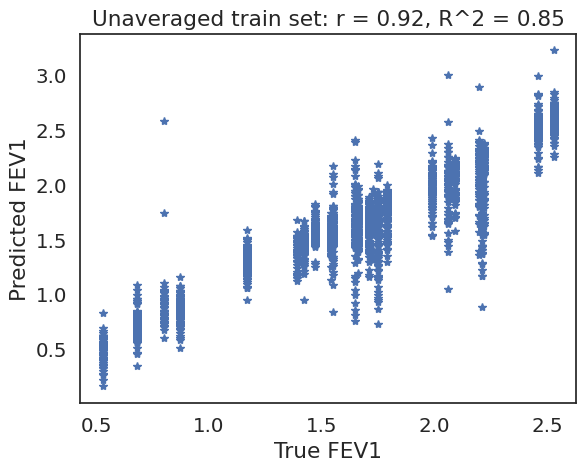

In [ ]:
# Train set performance
y_true = np.concatenate(y_train_fev1_true)
y_predicted = np.concatenate(y_train_fev1_pred)
visualize_results(y_true,y_predicted,'Unaveraged train set')

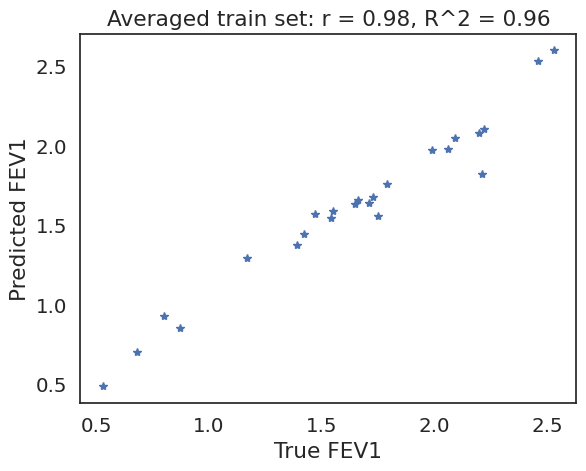

In [ ]:
# Train performance per subject
# Per subject performance
y_true = get_subj_fev1(np.concatenate(y_train_fev1_true),np.concatenate(y_train_subj_pred))
y_predicted = get_subj_fev1(np.concatenate(y_train_fev1_pred),np.concatenate(y_train_subj_pred))
visualize_results(y_true,y_predicted,'Averaged train set')

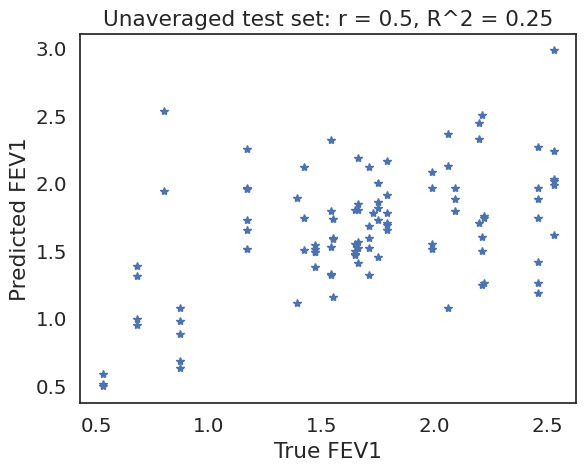

In [ ]:
# Test set performance
y_true = y_test_fev
y_predicted = y_test_fev1_pred
visualize_results(y_true,y_predicted,'Unaveraged test set')

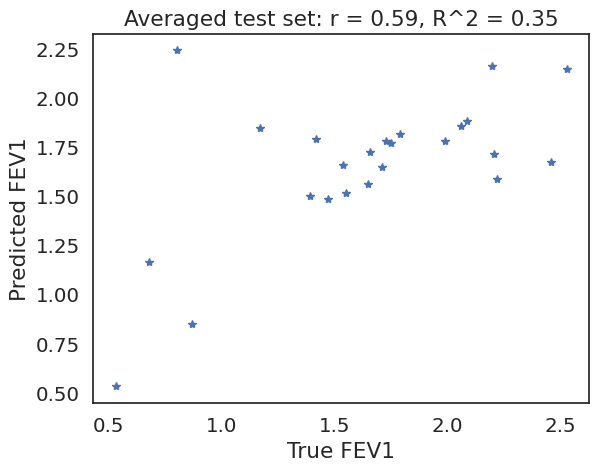

In [ ]:
# Test performance per subject
# Per subject performance
y_true = get_subj_fev1(y_test_fev,y_test_subj) # np.genfromtxt(modelpath+'240129_231621fev1_loso_fold_y_test_predicted.csv',delimiter=',')
y_predicted = get_subj_fev1(y_test_fev1_pred,y_test_subj)

visualize_results(y_true,y_predicted,'Averaged test set')

## FEV1 Estimator - No pretrained

### Evaluate on trained models

In [ ]:
modelspath = saved_models+'LOSO_FEV1_Models/FEV1_Estimator_subpretrain'
print(modelspath)
modelfiles = os.listdir(modelspath)
print(modelfiles)

/content/drive/My Drive/HeartFEV1 Project/Signal Processing and Machine Learning Code/saved_models/LOSO_FEV1_Models/FEV1_Estimator_subpretrain
['no_pretrain_n-015_240330_231206.hdf5', 'no_pretrain_n-014_240330_225626.hdf5', 'no_pretrain_n-012_240330_222411.hdf5', 'no_pretrain_n-007_240330_213518.hdf5', 'no_pretrain_n-013_240330_224048.hdf5', 'no_pretrain_n-006_240330_211843.hdf5', 'no_pretrain_n-009_240330_215058.hdf5', 'no_pretrain_n-010_240330_220734.hdf5', 'no_pretrain_n-004_240330_204530.hdf5', 'no_pretrain_n-005_240330_210208.hdf5', 'no_pretrain_c-012_240327_014409.hdf5', 'no_pretrain_n-003_240330_202855.hdf5', 'no_pretrain_c-020_240330_201112.hdf5', 'no_pretrain_c-015_240327_024250.hdf5', 'no_pretrain_c-016_240327_030338.hdf5', 'no_pretrain_c-017_240327_032215.hdf5', 'no_pretrain_c-011_240327_012633.hdf5', 'no_pretrain_c-008_240327_005318.hdf5', 'no_pretrain_c-013_240327_020048.hdf5', 'no_pretrain_c-010_240327_010956.hdf5', 'no_pretrain_c-007_240327_003729.hdf5', 'no_pretrain_c-0

In [ ]:
y_train_fev1_true = []
y_train_fev1_pred = []
y_train_subj_pred = []

y_test_fev1_pred = np.zeros_like(y_test_fev)
subjects_fold = np.unique(y_test_subj)
y_test_fev1_pred_per_subject = np.zeros((len(subjects_fold),2))
m = 0
now = datetime.datetime.now()
date_n = now.strftime("%y%m%d_%H%M%S")
print(date_n)
data_modeled = 'edr_fev1_loso'

240513_171850


In [ ]:
for fold in subjects_fold:
  print('DHMC Subject = ',fold)

  # Create train, val and test data
  idx_test = np.argwhere(y_test_subj==fold)[:,0]
  idx_train = np.argwhere(y_test_subj!=fold)[:,0]
  data_test_x = x_test[idx_test]
  data_test_y = y_test_r[idx_test]
  data_test_fev1 = y_test_fev[idx_test]
  data_train_x = x_test[idx_train]
  data_train_y = y_test_r[idx_train]
  data_train_fev1 = y_test_fev[idx_train]
  data_train_subjects = y_test_subj[idx_train]

  # Initialize model
  x_input = layers.Input(shape=(None,x_test.shape[2]),name='inputs')
  # Feature Extractor
  cnn1 = layers.Conv1D(8,5,padding='same',strides=3,activation='relu')(x_input)
  cnn2 = layers.Conv1D(4,7,padding='same',strides=5,activation='relu')(cnn1)
  # Classifier layer 1
  clss_1 = layers.Bidirectional(layers.GRU(16,activation='tanh', recurrent_activation='sigmoid',return_sequences=True))(cnn2)
  clss_2 = layers.Bidirectional(layers.GRU(8,activation='tanh', recurrent_activation='sigmoid',return_sequences=True))(clss_1)
  # Linear regression
  dense_reg = layers.Dense(2, activation='swish')(clss_2)
  reg_pred = layers.Dense(1, activation='linear',name='regression')(dense_reg)

  x_input_concat = layers.Concatenate()([cnn2,clss_2,reg_pred])
  gru_out = layers.Conv1D(10,9,activation='relu',strides=7,padding='same')(x_input_concat)
  batch_out = layers.BatchNormalization()(gru_out)
  gru_out = layers.Conv1D(10,9,activation='relu',strides=7,padding='same')(batch_out)
  batch_out = layers.BatchNormalization()(gru_out)
  pool1 = layers.GlobalAveragePooling1D()(batch_out)
  fev_pred = layers.Dense(1, activation='linear',name='fev1')(pool1)

  model = keras.Model(inputs=[x_input], outputs=[fev_pred])
  adam = tf.keras.optimizers.RMSprop(learning_rate=lr)
  model.compile(optimizer=adam,loss={'fev1':loss_fn},weighted_metrics=[loss_fn])
  # model.summary()

  # Get the LOSO model for this subject
  filepath_possibility = [i for i in modelfiles if fold in i]
  if len(filepath_possibility) != 1:
    raise SystemError('Multiple filepaths detected for subject. Please pick one')

  # Model Performance
  filepath = modelspath+'/'+filepath_possibility[0]
  model.load_weights(filepath)
  model.compile(optimizer=adam, loss={'fev1':loss_fn})
  # Train set performance
  results_train = model.evaluate({'inputs':data_train_x},{'fev1':data_train_fev1},batch_size=batch_size,verbose = 1)
  # print(results_train)
  y_train_pred_fev1 = model.predict(data_train_x)
  y_train_fev1_true.append(data_train_fev1)
  y_train_fev1_pred.append(y_train_pred_fev1[:,0])
  y_train_subj_pred.append(data_train_subjects)
  # Get average subject performance
  y_train_true = get_subj_fev1(data_train_fev1,data_train_subjects)
  y_train_predicted = get_subj_fev1(y_train_pred_fev1[:,0],data_train_subjects)
  # Compute regression
  slope_rr_train, intercept_rr_train, r_rr_train, p_val_r_train, se_rr_train = linregress(y_train_true,y_train_predicted)

  # Test set performance
  results_test = model.evaluate({'inputs':data_test_x},{'fev1':data_test_fev1},batch_size=batch_size,verbose = 1)
  # print(results_test)
  y_test_pred_fev1 = model.predict(data_test_x)
  y_test_fev1_pred[idx_test] = y_test_pred_fev1[:,0]

  del model
  gc.collect()
  m = m+1

DHMC Subject =  c-002
1/1 [==============================] - 0s 307ms/step
DHMC Subject =  c-003
1/1 [==============================] - 0s 296ms/step
DHMC Subject =  c-004
1/1 [==============================] - 0s 296ms/step
DHMC Subject =  c-007
1/1 [==============================] - 0s 479ms/step
DHMC Subject =  c-008
1/1 [==============================] - 1s 556ms/step
DHMC Subject =  c-010
1/1 [==============================] - 1s 553ms/step
DHMC Subject =  c-011
1/1 [==============================] - 0s 302ms/step
DHMC Subject =  c-012
1/1 [==============================] - 2s 2s/step
DHMC Subject =  c-013
1/1 [==============================] - 0s 304ms/step
DHMC Subject =  c-015
1/1 [==============================] - 0s 295ms/step
DHMC Subject =  c-016
1/1 [==============================] - 0s 299ms/step
DHMC Subject =  c-017
1/1 [==============================] - 1s 548ms/step
DHMC Subject =  c-020
1/1 [==============================] - 2s 2s/step
DHMC Subject =  n-003
1/1 [====

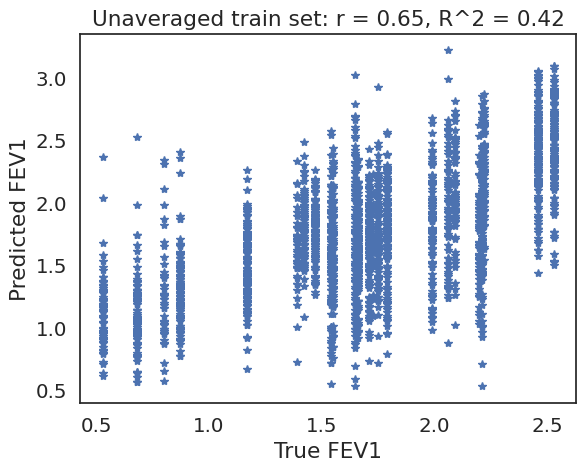

In [ ]:
# Train set performance
y_true = np.concatenate(y_train_fev1_true)
y_predicted = np.concatenate(y_train_fev1_pred)
visualize_results(y_true,y_predicted,'Unaveraged train set')

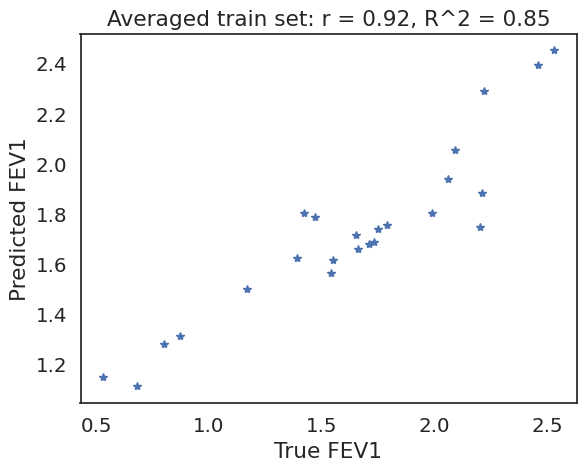

In [ ]:
# Train performance per subject
# Per subject performance
y_true = get_subj_fev1(np.concatenate(y_train_fev1_true),np.concatenate(y_train_subj_pred))
y_predicted = get_subj_fev1(np.concatenate(y_train_fev1_pred),np.concatenate(y_train_subj_pred))
visualize_results(y_true,y_predicted,'Averaged train set')

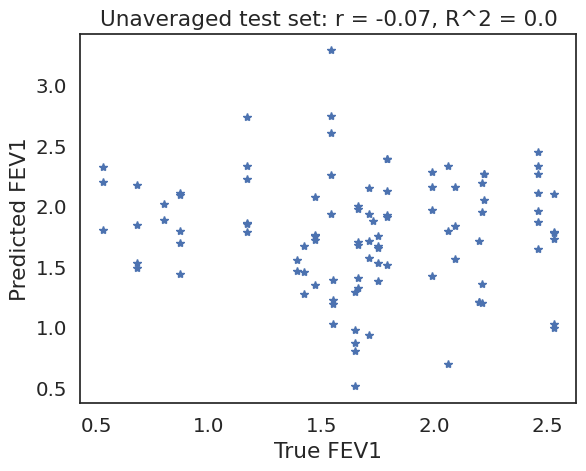

In [ ]:
# Test set performance
y_true = y_test_fev
y_predicted = y_test_fev1_pred
visualize_results(y_true,y_predicted,'Unaveraged test set')

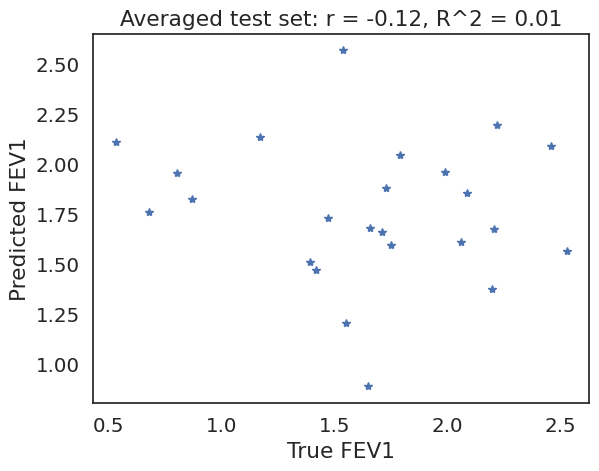

In [ ]:
# Test performance per subject
# Per subject performance
y_true = get_subj_fev1(y_test_fev,y_test_subj) # np.genfromtxt(modelpath+'240129_231621fev1_loso_fold_y_test_predicted.csv',delimiter=',')
y_predicted = get_subj_fev1(y_test_fev1_pred,y_test_subj)

visualize_results(y_true,y_predicted,'Averaged test set')

# Train Models

In [ ]:
x_test,y_test_r,y_test_fev,y_test_subj = ECG_dhmc,RESP_dhmc,fev1_dhmc,subjects_left_dhmc

print(x_test.shape,y_test_r.shape,y_test_fev.shape,y_test_subj.shape)

(100, 27000, 1) (100, 1800, 1) (100,) (100,)


## FEV1 Estimator - LOSO

### Create inputs

In [ ]:
# Initialize EDR signal
x_input = layers.Input(shape=(None,x_test.shape[2]),name='inputs')
# Feature Extractor
cnn1 = layers.Conv1D(8,5,padding='same',strides=3,activation='relu')(x_input)
cnn2 = layers.Conv1D(4,7,padding='same',strides=5,activation='relu')(cnn1)
# Classifier layer 1
clss_1 = layers.Bidirectional(layers.GRU(16,activation='tanh', recurrent_activation='sigmoid',return_sequences=True))(cnn2)
clss_2 = layers.Bidirectional(layers.GRU(8,activation='tanh', recurrent_activation='sigmoid',return_sequences=True))(clss_1)
# Linear regression
dense_reg = layers.Dense(2, activation='swish')(clss_2)
reg_pred = layers.Dense(1, activation='linear',name='regression')(dense_reg)
# Instantiate an end-to-end model predicting both priority and department
model_edr = keras.Model(inputs=[x_input], outputs=[reg_pred])
adam = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model_edr.compile(optimizer=adam, loss={'regression':'mse'})
model_edr.summary()
# Compile the model
model_edr.load_weights(saved_models+'worst_case_240207_200203.hdf5')

Model: "model_162"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None, 1)]         0         
                                                                 
 conv1d_372 (Conv1D)         (None, None, 8)           48        
                                                                 
 conv1d_373 (Conv1D)         (None, None, 4)           228       
                                                                 
 bidirectional_72 (Bidirect  (None, None, 32)          2112      
 ional)                                                          
                                                                 
 bidirectional_73 (Bidirect  (None, None, 16)          2016      
 ional)                                                          
                                                                 
 dense_31 (Dense)            (None, None, 2)           34

In [ ]:
# Model 1
x_input = layers.Input(shape=(None,x_test.shape[2]),name='inputs')
# Feature Extractor
cnn1 = layers.Conv1D(8,5,padding='same',strides=3,activation='relu')(x_input)
cnn2 = layers.Conv1D(4,7,padding='same',strides=5,activation='relu')(cnn1)
model1 = keras.Model(inputs=[x_input], outputs=[cnn2])
adam = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model1.compile(optimizer=adam, loss={'regression':'mse'})
# Initialize EDR Algorithm weights
model1.layers[1].set_weights(model_edr.layers[1].get_weights())
model1.layers[2].set_weights(model_edr.layers[2].get_weights())
model1.layers[1].trainable = False
model1.layers[2].trainable = False
model1.summary()

cnn2_in = model1.predict(x_test)
print(cnn2_in.shape)

Model: "model_163"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None, 1)]         0         
                                                                 
 conv1d_374 (Conv1D)         (None, None, 8)           48        
                                                                 
 conv1d_375 (Conv1D)         (None, None, 4)           228       
                                                                 
Total params: 276 (1.08 KB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 276 (1.08 KB)
_________________________________________________________________
4/4 [==============================] - 0s 60ms/step
(100, 1800, 4)


In [ ]:
# Model 2
x_input = layers.Input(shape=(None,x_test.shape[2]),name='inputs')
# Feature Extractor
cnn1 = layers.Conv1D(8,5,padding='same',strides=3,activation='relu')(x_input)
cnn2 = layers.Conv1D(4,7,padding='same',strides=5,activation='relu')(cnn1)
# Classifier layer 1
clss_1 = layers.Bidirectional(layers.GRU(16,activation='tanh', recurrent_activation='sigmoid',return_sequences=True))(cnn2)
clss_2 = layers.Bidirectional(layers.GRU(8,activation='tanh', recurrent_activation='sigmoid',return_sequences=True))(clss_1)
model2 = keras.Model(inputs=[x_input], outputs=[clss_2])
adam = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model2.compile(optimizer=adam, loss={'regression':'mse'})
# Initialize EDR Algorithm weights
model2.layers[1].set_weights(model_edr.layers[1].get_weights())
model2.layers[2].set_weights(model_edr.layers[2].get_weights())
model2.layers[3].set_weights(model_edr.layers[3].get_weights())
model2.layers[4].set_weights(model_edr.layers[4].get_weights())
model2.layers[1].trainable = False
model2.layers[2].trainable = False
model2.layers[3].trainable = False
model2.layers[4].trainable = False
model2.summary()

clss_2_in = model2.predict(x_test)
print(clss_2_in.shape)

Model: "model_164"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None, 1)]         0         
                                                                 
 conv1d_376 (Conv1D)         (None, None, 8)           48        
                                                                 
 conv1d_377 (Conv1D)         (None, None, 4)           228       
                                                                 
 bidirectional_74 (Bidirect  (None, None, 32)          2112      
 ional)                                                          
                                                                 
 bidirectional_75 (Bidirect  (None, None, 16)          2016      
 ional)                                                          
                                                                 
Total params: 4404 (17.20 KB)
Trainable params: 0 (0.00 B

In [ ]:
reg_pred_in = model_edr.predict(x_test)
print(reg_pred_in.shape)

4/4 [==============================] - 9s 603ms/step
(100, 1800, 1)


In [ ]:
x_test_new = np.concatenate((cnn2_in,clss_2_in,reg_pred_in),axis=2)
print(x_test_new.shape)

(100, 1800, 21)


### Perfect Case

In [ ]:
y_train_fev1_true = []
y_train_fev1_pred = []
y_train_subj_pred = []

y_test_fev1_pred = np.zeros_like(y_test_fev)
subjects_fold = np.unique(y_test_subj)
y_test_fev1_pred_per_subject = np.zeros((len(subjects_fold),2))
m = 0
now = datetime.datetime.now()
date_n = now.strftime("%y%m%d_%H%M%S")
print(date_n)
data_modeled = 'edr_fev1_loso'

240513_173550


In [ ]:
for fold in subjects_fold:
  print('DHMC Subject = ',fold)

  # Create train, val and test data
  idx_test = np.argwhere(y_test_subj==fold)[:,0]
  idx_train = np.argwhere(y_test_subj!=fold)[:,0]
  data_test_x = x_test_new[idx_test]
  data_test_y = y_test_r[idx_test]
  data_test_fev1 = y_test_fev[idx_test]
  data_train_x = x_test_new[idx_train]
  data_train_y = y_test_r[idx_train]
  data_train_fev1 = y_test_fev[idx_train]
  data_train_subjects = y_test_subj[idx_train]

  # Initialize model
  x_input = layers.Input(shape=(data_train_x.shape[1],data_train_x.shape[2]),name='inputs')
  gru_out = layers.Conv1D(10,9,activation='relu',strides=7,padding='same')(x_input)
  batch_out = layers.BatchNormalization()(gru_out)
  gru_out = layers.Conv1D(10,9,activation='relu',strides=7,padding='same')(batch_out)
  batch_out = layers.BatchNormalization()(gru_out)
  pool1 = layers.GlobalAveragePooling1D()(batch_out)
  fev_pred = layers.Dense(1, activation='linear',name='fev1')(pool1)

  model = keras.Model(inputs=[x_input], outputs=[fev_pred])
  adam = tf.keras.optimizers.RMSprop(learning_rate=lr)
  model.compile(optimizer=adam,loss={'fev1':loss_fn},weighted_metrics=[loss_fn])
  model.summary()

  # checkpoint
  now = datetime.datetime.now()
  s1 = now.strftime("%y%m%d_%H%M%S")
  filepath= ('resp_'+fold+'_'+s1+'.hdf5')
  checkpoint = ModelCheckpoint(filepath, monitor='val_'+loss_fn, verbose=1, save_best_only=True, mode='min')
  early_Stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
  callbacks_list = [checkpoint]
  samp_wt = get_sample_weights(data_train_fev1)

  # Train model
  history = model.fit({'inputs':data_train_x},{'fev1':data_train_fev1},epochs=num_epochs,batch_size=batch_size,
                      validation_data=({'inputs':data_test_x},{'fev1':data_test_fev1}),shuffle=True,verbose=False,callbacks=callbacks_list,sample_weight=samp_wt)
  # Model Performance
  model.load_weights(filepath)
  model.compile(optimizer=adam, loss={'fev1':loss_fn})
  # Train set performance
  results_train = model.evaluate({'inputs':data_train_x},{'fev1':data_train_fev1},batch_size=batch_size,verbose = 1)
  print(results_train)
  y_train_pred_fev1 = model.predict(data_train_x)
  y_train_fev1_true.append(data_train_fev1)
  y_train_fev1_pred.append(y_train_pred_fev1[:,0])
  y_train_subj_pred.append(data_train_subjects)
  # Get average subject performance
  y_train_true = get_subj_fev1(data_train_fev1,data_train_subjects)
  y_train_predicted = get_subj_fev1(y_train_pred_fev1[:,0],data_train_subjects)
  # Compute regression
  slope_rr_train, intercept_rr_train, r_rr_train, p_val_r_train, se_rr_train = linregress(y_train_true,y_train_predicted)

  # Test set performance
  results_test = model.evaluate({'inputs':data_test_x},{'fev1':data_test_fev1},batch_size=batch_size,verbose = 1)
  print(results_test)
  y_test_pred_fev1 = model.predict(data_test_x)
  y_test_fev1_pred[idx_test] = y_test_pred_fev1[:,0]

  del model
  gc.collect()
  m = m+1

DHMC Subject =  c-002
Model: "model_165"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_378 (Conv1D)         (None, 258, 10)           1900      
                                                                 
 batch_normalization_290 (B  (None, 258, 10)           40        
 atchNormalization)                                              
                                                                 
 conv1d_379 (Conv1D)         (None, 37, 10)            910       
                                                                 
 batch_normalization_291 (B  (None, 37, 10)            40        
 atchNormalization)                                              
                                                                 
 global_average_pooling1d_1  (None,

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_mse improved from 6.85488 to 6.79306, saving model to resp_c-002_240513_173553.hdf5

Epoch 3: val_mse improved from 6.79306 to 6.73792, saving model to resp_c-002_240513_173553.hdf5

Epoch 4: val_mse improved from 6.73792 to 6.68506, saving model to resp_c-002_240513_173553.hdf5

Epoch 5: val_mse improved from 6.68506 to 6.63495, saving model to resp_c-002_240513_173553.hdf5

Epoch 6: val_mse improved from 6.63495 to 6.55364, saving model to resp_c-002_240513_173553.hdf5

Epoch 7: val_mse improved from 6.55364 to 6.48650, saving model to resp_c-002_240513_173553.hdf5

Epoch 8: val_mse improved from 6.48650 to 6.44148, saving model to resp_c-002_240513_173553.hdf5

Epoch 9: val_mse improved from 6.44148 to 6.38896, saving model to resp_c-002_240513_173553.hdf5

Epoch 10: val_mse improved from 6.38896 to 6.34761, saving model to resp_c-002_240513_173553.hdf5

Epoch 11: val_mse improved from 6.34761 to 6.31608, saving model to resp_c-002_240513_173553.hdf5

Epoch 12: val_mse

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_mse did not improve from 1.76145

Epoch 3: val_mse did not improve from 1.76145

Epoch 4: val_mse did not improve from 1.76145

Epoch 5: val_mse did not improve from 1.76145

Epoch 6: val_mse did not improve from 1.76145

Epoch 7: val_mse did not improve from 1.76145

Epoch 8: val_mse did not improve from 1.76145

Epoch 9: val_mse did not improve from 1.76145

Epoch 10: val_mse did not improve from 1.76145

Epoch 11: val_mse did not improve from 1.76145

Epoch 12: val_mse did not improve from 1.76145

Epoch 13: val_mse did not improve from 1.76145

Epoch 14: val_mse did not improve from 1.76145

Epoch 15: val_mse did not improve from 1.76145

Epoch 16: val_mse did not improve from 1.76145

Epoch 17: val_mse did not improve from 1.76145

Epoch 18: val_mse did not improve from 1.76145

Epoch 19: val_mse did not improve from 1.76145

Epoch 20: val_mse did not improve from 1.76145

Epoch 21: val_mse did not improve from 1.76145

Epoch 22: val_mse did not improve from 1.76145


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: val_mse did not improve from 0.08701

Epoch 4: val_mse did not improve from 0.08701

Epoch 5: val_mse did not improve from 0.08701

Epoch 6: val_mse did not improve from 0.08701

Epoch 7: val_mse did not improve from 0.08701

Epoch 8: val_mse did not improve from 0.08701

Epoch 9: val_mse did not improve from 0.08701

Epoch 10: val_mse did not improve from 0.08701

Epoch 11: val_mse did not improve from 0.08701

Epoch 12: val_mse did not improve from 0.08701

Epoch 13: val_mse did not improve from 0.08701

Epoch 14: val_mse did not improve from 0.08701

Epoch 15: val_mse did not improve from 0.08701

Epoch 16: val_mse did not improve from 0.08701

Epoch 17: val_mse did not improve from 0.08701

Epoch 18: val_mse did not improve from 0.08701

Epoch 19: val_mse did not improve from 0.08701

Epoch 20: val_mse did not improve from 0.08701

Epoch 21: val_mse did not improve from 0.08701

Epoch 22: val_mse did not improve from 0.08701

Epoch 23: val_mse did not improve from 0.08701

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: val_mse improved from 2.98798 to 2.64384, saving model to resp_c-007_240513_174025.hdf5

Epoch 4: val_mse improved from 2.64384 to 2.34784, saving model to resp_c-007_240513_174025.hdf5

Epoch 5: val_mse improved from 2.34784 to 2.09916, saving model to resp_c-007_240513_174025.hdf5

Epoch 6: val_mse improved from 2.09916 to 1.88110, saving model to resp_c-007_240513_174025.hdf5

Epoch 7: val_mse improved from 1.88110 to 1.68671, saving model to resp_c-007_240513_174025.hdf5

Epoch 8: val_mse improved from 1.68671 to 1.53378, saving model to resp_c-007_240513_174025.hdf5

Epoch 9: val_mse improved from 1.53378 to 1.40470, saving model to resp_c-007_240513_174025.hdf5

Epoch 10: val_mse improved from 1.40470 to 1.31076, saving model to resp_c-007_240513_174025.hdf5

Epoch 11: val_mse improved from 1.31076 to 1.21584, saving model to resp_c-007_240513_174025.hdf5

Epoch 12: val_mse improved from 1.21584 to 1.16674, saving model to resp_c-007_240513_174025.hdf5

Epoch 13: val_ms

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: val_mse improved from 0.08389 to 0.06772, saving model to resp_c-008_240513_174148.hdf5

Epoch 4: val_mse improved from 0.06772 to 0.05570, saving model to resp_c-008_240513_174148.hdf5

Epoch 5: val_mse improved from 0.05570 to 0.04821, saving model to resp_c-008_240513_174148.hdf5

Epoch 6: val_mse improved from 0.04821 to 0.04368, saving model to resp_c-008_240513_174148.hdf5

Epoch 7: val_mse improved from 0.04368 to 0.04058, saving model to resp_c-008_240513_174148.hdf5

Epoch 8: val_mse improved from 0.04058 to 0.03972, saving model to resp_c-008_240513_174148.hdf5

Epoch 9: val_mse improved from 0.03972 to 0.03695, saving model to resp_c-008_240513_174148.hdf5

Epoch 10: val_mse did not improve from 0.03695

Epoch 11: val_mse did not improve from 0.03695

Epoch 12: val_mse did not improve from 0.03695

Epoch 13: val_mse did not improve from 0.03695

Epoch 14: val_mse did not improve from 0.03695

Epoch 15: val_mse did not improve from 0.03695

Epoch 16: val_mse did not

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: val_mse did not improve from 3.51320

Epoch 4: val_mse did not improve from 3.51320

Epoch 5: val_mse did not improve from 3.51320

Epoch 6: val_mse did not improve from 3.51320

Epoch 7: val_mse did not improve from 3.51320

Epoch 8: val_mse improved from 3.51320 to 3.50743, saving model to resp_c-010_240513_174305.hdf5

Epoch 9: val_mse improved from 3.50743 to 3.45758, saving model to resp_c-010_240513_174305.hdf5

Epoch 10: val_mse improved from 3.45758 to 3.40528, saving model to resp_c-010_240513_174305.hdf5

Epoch 11: val_mse improved from 3.40528 to 3.35166, saving model to resp_c-010_240513_174305.hdf5

Epoch 12: val_mse improved from 3.35166 to 3.31662, saving model to resp_c-010_240513_174305.hdf5

Epoch 13: val_mse improved from 3.31662 to 3.25278, saving model to resp_c-010_240513_174305.hdf5

Epoch 14: val_mse improved from 3.25278 to 3.20394, saving model to resp_c-010_240513_174305.hdf5

Epoch 15: val_mse improved from 3.20394 to 3.15083, saving model to resp_

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: val_mse improved from 3.72691 to 3.48492, saving model to resp_c-011_240513_174424.hdf5

Epoch 4: val_mse improved from 3.48492 to 3.26904, saving model to resp_c-011_240513_174424.hdf5

Epoch 5: val_mse improved from 3.26904 to 3.08870, saving model to resp_c-011_240513_174424.hdf5

Epoch 6: val_mse improved from 3.08870 to 2.93544, saving model to resp_c-011_240513_174424.hdf5

Epoch 7: val_mse improved from 2.93544 to 2.82289, saving model to resp_c-011_240513_174424.hdf5

Epoch 8: val_mse improved from 2.82289 to 2.72423, saving model to resp_c-011_240513_174424.hdf5

Epoch 9: val_mse improved from 2.72423 to 2.62115, saving model to resp_c-011_240513_174424.hdf5

Epoch 10: val_mse improved from 2.62115 to 2.54312, saving model to resp_c-011_240513_174424.hdf5

Epoch 11: val_mse improved from 2.54312 to 2.44610, saving model to resp_c-011_240513_174424.hdf5

Epoch 12: val_mse improved from 2.44610 to 2.40540, saving model to resp_c-011_240513_174424.hdf5

Epoch 13: val_ms

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: val_mse did not improve from 0.37518

Epoch 4: val_mse did not improve from 0.37518

Epoch 5: val_mse improved from 0.37518 to 0.37060, saving model to resp_c-012_240513_174549.hdf5

Epoch 6: val_mse improved from 0.37060 to 0.35072, saving model to resp_c-012_240513_174549.hdf5

Epoch 7: val_mse improved from 0.35072 to 0.31945, saving model to resp_c-012_240513_174549.hdf5

Epoch 8: val_mse improved from 0.31945 to 0.29860, saving model to resp_c-012_240513_174549.hdf5

Epoch 9: val_mse improved from 0.29860 to 0.28239, saving model to resp_c-012_240513_174549.hdf5

Epoch 10: val_mse improved from 0.28239 to 0.26764, saving model to resp_c-012_240513_174549.hdf5

Epoch 11: val_mse improved from 0.26764 to 0.23778, saving model to resp_c-012_240513_174549.hdf5

Epoch 12: val_mse did not improve from 0.23778

Epoch 13: val_mse improved from 0.23778 to 0.21835, saving model to resp_c-012_240513_174549.hdf5

Epoch 14: val_mse improved from 0.21835 to 0.20879, saving model to re

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: val_mse did not improve from 2.53834

Epoch 4: val_mse did not improve from 2.53834

Epoch 5: val_mse did not improve from 2.53834

Epoch 6: val_mse did not improve from 2.53834

Epoch 7: val_mse did not improve from 2.53834

Epoch 8: val_mse did not improve from 2.53834

Epoch 9: val_mse did not improve from 2.53834

Epoch 10: val_mse did not improve from 2.53834

Epoch 11: val_mse did not improve from 2.53834

Epoch 12: val_mse did not improve from 2.53834

Epoch 13: val_mse did not improve from 2.53834

Epoch 14: val_mse did not improve from 2.53834

Epoch 15: val_mse did not improve from 2.53834

Epoch 16: val_mse did not improve from 2.53834

Epoch 17: val_mse did not improve from 2.53834

Epoch 18: val_mse did not improve from 2.53834

Epoch 19: val_mse did not improve from 2.53834

Epoch 20: val_mse did not improve from 2.53834

Epoch 21: val_mse did not improve from 2.53834

Epoch 22: val_mse did not improve from 2.53834

Epoch 23: val_mse did not improve from 2.53834

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_mse did not improve from 6.58854

Epoch 3: val_mse did not improve from 6.58854

Epoch 4: val_mse did not improve from 6.58854

Epoch 5: val_mse did not improve from 6.58854

Epoch 6: val_mse did not improve from 6.58854

Epoch 7: val_mse did not improve from 6.58854

Epoch 8: val_mse did not improve from 6.58854

Epoch 9: val_mse did not improve from 6.58854

Epoch 10: val_mse did not improve from 6.58854

Epoch 11: val_mse did not improve from 6.58854

Epoch 12: val_mse did not improve from 6.58854

Epoch 13: val_mse did not improve from 6.58854

Epoch 14: val_mse did not improve from 6.58854

Epoch 15: val_mse did not improve from 6.58854

Epoch 16: val_mse did not improve from 6.58854

Epoch 17: val_mse did not improve from 6.58854

Epoch 18: val_mse improved from 6.58854 to 6.51754, saving model to resp_c-015_240513_174832.hdf5

Epoch 19: val_mse improved from 6.51754 to 6.36613, saving model to resp_c-015_240513_174832.hdf5

Epoch 20: val_mse improved from 6.36613 t

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_mse improved from 1.90548 to 1.80999, saving model to resp_c-016_240513_174948.hdf5

Epoch 3: val_mse improved from 1.80999 to 1.71754, saving model to resp_c-016_240513_174948.hdf5

Epoch 4: val_mse improved from 1.71754 to 1.62947, saving model to resp_c-016_240513_174948.hdf5

Epoch 5: val_mse improved from 1.62947 to 1.54641, saving model to resp_c-016_240513_174948.hdf5

Epoch 6: val_mse improved from 1.54641 to 1.47171, saving model to resp_c-016_240513_174948.hdf5

Epoch 7: val_mse improved from 1.47171 to 1.39934, saving model to resp_c-016_240513_174948.hdf5

Epoch 8: val_mse improved from 1.39934 to 1.34917, saving model to resp_c-016_240513_174948.hdf5

Epoch 9: val_mse improved from 1.34917 to 1.28976, saving model to resp_c-016_240513_174948.hdf5

Epoch 10: val_mse improved from 1.28976 to 1.22281, saving model to resp_c-016_240513_174948.hdf5

Epoch 11: val_mse improved from 1.22281 to 1.18360, saving model to resp_c-016_240513_174948.hdf5

Epoch 12: val_mse

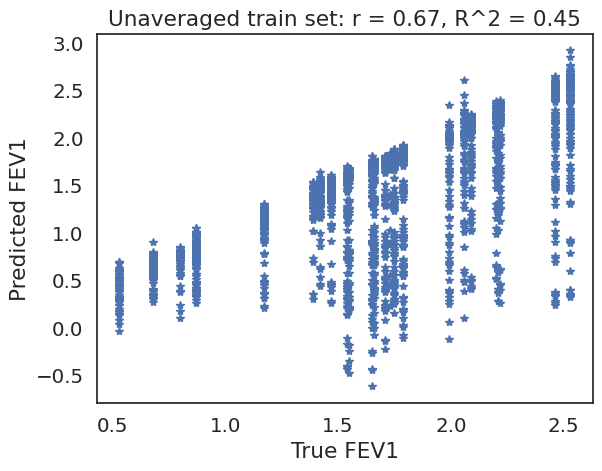

In [ ]:
# Train set performance
y_true = np.concatenate(y_train_fev1_true)
y_predicted = np.concatenate(y_train_fev1_pred)
visualize_results(y_true,y_predicted,'Unaveraged train set')

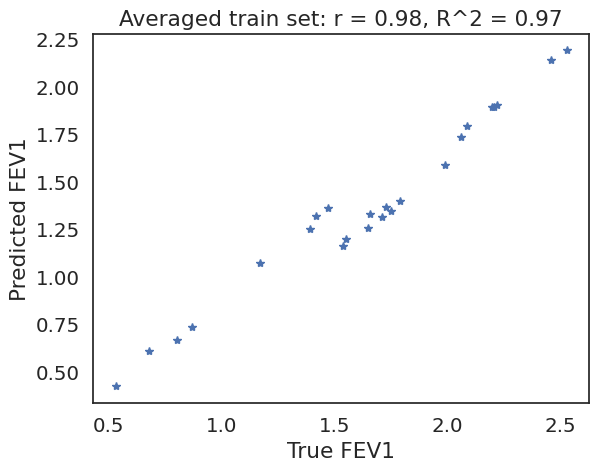

In [ ]:
# Train performance per subject
# Per subject performance
y_true = get_subj_fev1(np.concatenate(y_train_fev1_true),np.concatenate(y_train_subj_pred))
y_predicted = get_subj_fev1(np.concatenate(y_train_fev1_pred),np.concatenate(y_train_subj_pred))
visualize_results(y_true,y_predicted,'Averaged train set')

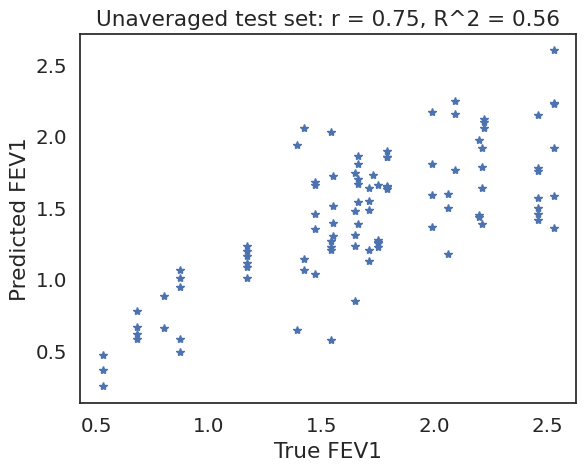

In [ ]:
# Test set performance
y_true = y_test_fev
y_predicted = y_test_fev1_pred
visualize_results(y_true,y_predicted,'Unaveraged test set')

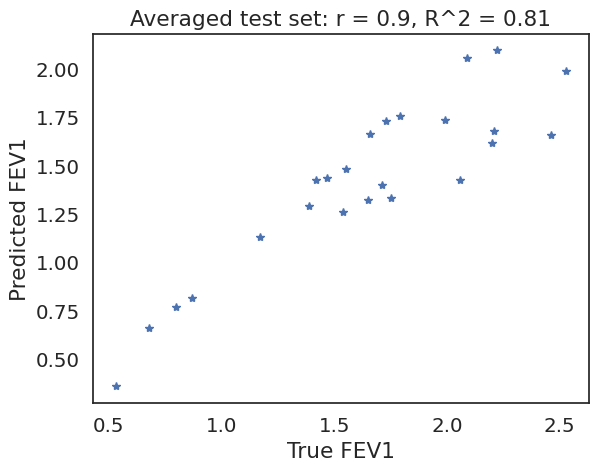

In [ ]:
# Test performance per subject
# Per subject performance
y_true = get_subj_fev1(y_test_fev,y_test_subj) # np.genfromtxt(modelpath+'240129_231621fev1_loso_fold_y_test_predicted.csv',delimiter=',')
y_predicted = get_subj_fev1(y_test_fev1_pred,y_test_subj)

visualize_results(y_true,y_predicted,'Averaged test set')

### Model

In [ ]:
y_train_fev1_true = []
y_train_fev1_pred = []
y_train_subj_pred = []

y_test_fev1_pred = np.zeros_like(y_test_fev)
subjects_fold = np.unique(y_test_subj)
y_test_fev1_pred_per_subject = np.zeros((len(subjects_fold),2))
m = 0
now = datetime.datetime.now()
date_n = now.strftime("%y%m%d_%H%M%S")
print(date_n)
data_modeled = 'edr_fev1_loso'

240326_054111


In [ ]:
subjects_fold

array(['c-002', 'c-003', 'c-004', 'c-007', 'c-008', 'c-010', 'c-011',
       'c-012', 'c-013', 'c-015', 'c-016', 'c-017', 'c-020', 'n-003',
       'n-004', 'n-005', 'n-006', 'n-007', 'n-009', 'n-010', 'n-012',
       'n-013', 'n-014', 'n-015'], dtype='<U5')

In [ ]:
for fold in subjects_fold:
  print('DHMC Subject = ',fold)

  # Create train, val and test data
  idx_test = np.argwhere(y_test_subj==fold)[:,0]
  idx_train = np.argwhere(y_test_subj!=fold)[:,0]
  data_test_x = x_test_new[idx_test]
  data_test_y = y_test_r[idx_test]
  data_test_fev1 = y_test_fev[idx_test]
  data_train_x = x_test_new[idx_train]
  data_train_y = y_test_r[idx_train]
  data_train_fev1 = y_test_fev[idx_train]
  data_train_subjects = y_test_subj[idx_train]

  # Initialize model
  x_input = layers.Input(shape=(data_train_x.shape[1],data_train_x.shape[2]),name='inputs')
  gru_out = layers.Conv1D(10,9,activation='relu',strides=7,padding='same')(x_input)
  batch_out = layers.BatchNormalization()(gru_out)
  gru_out = layers.Conv1D(10,9,activation='relu',strides=7,padding='same')(batch_out)
  batch_out = layers.BatchNormalization()(gru_out)
  pool1 = layers.GlobalAveragePooling1D()(batch_out)
  fev_pred = layers.Dense(1, activation='linear',name='fev1')(pool1)

  model = keras.Model(inputs=[x_input], outputs=[fev_pred])
  adam = tf.keras.optimizers.RMSprop(learning_rate=lr)
  model.compile(optimizer=adam,loss={'fev1':loss_fn},weighted_metrics=[loss_fn])
  model.summary()

  # checkpoint
  now = datetime.datetime.now()
  s1 = now.strftime("%y%m%d_%H%M%S")
  filepath= ('resp_'+fold+'_'+s1+'.hdf5')
  checkpoint = ModelCheckpoint(filepath, monitor='val_'+loss_fn, verbose=1, save_best_only=True, mode='min')
  early_Stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
  callbacks_list = [checkpoint]
  samp_wt = get_sample_weights(data_train_fev1)

  # Train model
  history = model.fit({'inputs':data_train_x},{'fev1':data_train_fev1},epochs=num_epochs,batch_size=batch_size,
                      validation_split=0.2,shuffle=True,verbose=False,callbacks=callbacks_list)#,sample_weight=samp_wt)
  # Model Performance
  model.load_weights(filepath)
  model.compile(optimizer=adam, loss={'fev1':loss_fn})
  # Train set performance
  results_train = model.evaluate({'inputs':data_train_x},{'fev1':data_train_fev1},batch_size=batch_size,verbose = 1)
  print(results_train)
  y_train_pred_fev1 = model.predict(data_train_x)
  y_train_fev1_true.append(data_train_fev1)
  y_train_fev1_pred.append(y_train_pred_fev1[:,0])
  y_train_subj_pred.append(data_train_subjects)
  # Get average subject performance
  y_train_true = get_subj_fev1(data_train_fev1,data_train_subjects)
  y_train_predicted = get_subj_fev1(y_train_pred_fev1[:,0],data_train_subjects)
  # Compute regression
  slope_rr_train, intercept_rr_train, r_rr_train, p_val_r_train, se_rr_train = linregress(y_train_true,y_train_predicted)

  # Test set performance
  results_test = model.evaluate({'inputs':data_test_x},{'fev1':data_test_fev1},batch_size=batch_size,verbose = 1)
  print(results_test)
  y_test_pred_fev1 = model.predict(data_test_x)
  y_test_fev1_pred[idx_test] = y_test_pred_fev1[:,0]

  del model
  gc.collect()
  m = m+1

DHMC Subject =  c-002
Model: "model_151"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_302 (Conv1D)         (None, 258, 10)           1900      
                                                                 
 batch_normalization_266 (B  (None, 258, 10)           40        
 atchNormalization)                                              
                                                                 
 conv1d_303 (Conv1D)         (None, 37, 10)            910       
                                                                 
 batch_normalization_267 (B  (None, 37, 10)            40        
 atchNormalization)                                              
                                                                 
 global_average_pooling1d_1  (None,

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: val_mse improved from 4.69708 to 4.38956, saving model to resp_c-002_240326_054111.hdf5

Epoch 4: val_mse improved from 4.38956 to 4.10825, saving model to resp_c-002_240326_054111.hdf5

Epoch 5: val_mse improved from 4.10825 to 3.86444, saving model to resp_c-002_240326_054111.hdf5

Epoch 6: val_mse improved from 3.86444 to 3.63556, saving model to resp_c-002_240326_054111.hdf5

Epoch 7: val_mse improved from 3.63556 to 3.43433, saving model to resp_c-002_240326_054111.hdf5

Epoch 8: val_mse improved from 3.43433 to 3.25113, saving model to resp_c-002_240326_054111.hdf5

Epoch 9: val_mse improved from 3.25113 to 3.13293, saving model to resp_c-002_240326_054111.hdf5

Epoch 10: val_mse improved from 3.13293 to 3.00030, saving model to resp_c-002_240326_054111.hdf5

Epoch 11: val_mse improved from 3.00030 to 2.87592, saving model to resp_c-002_240326_054111.hdf5

Epoch 12: val_mse improved from 2.87592 to 2.76047, saving model to resp_c-002_240326_054111.hdf5

Epoch 13: val_ms

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: val_mse improved from 3.91522 to 3.89832, saving model to resp_c-003_240326_054204.hdf5

Epoch 4: val_mse improved from 3.89832 to 3.88800, saving model to resp_c-003_240326_054204.hdf5

Epoch 5: val_mse improved from 3.88800 to 3.86840, saving model to resp_c-003_240326_054204.hdf5

Epoch 6: val_mse improved from 3.86840 to 3.84124, saving model to resp_c-003_240326_054204.hdf5

Epoch 7: val_mse improved from 3.84124 to 3.81880, saving model to resp_c-003_240326_054204.hdf5

Epoch 8: val_mse improved from 3.81880 to 3.79863, saving model to resp_c-003_240326_054204.hdf5

Epoch 9: val_mse improved from 3.79863 to 3.78305, saving model to resp_c-003_240326_054204.hdf5

Epoch 10: val_mse improved from 3.78305 to 3.76509, saving model to resp_c-003_240326_054204.hdf5

Epoch 11: val_mse improved from 3.76509 to 3.73216, saving model to resp_c-003_240326_054204.hdf5

Epoch 12: val_mse improved from 3.73216 to 3.71496, saving model to resp_c-003_240326_054204.hdf5

Epoch 13: val_ms

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: val_mse did not improve from 2.30138

Epoch 4: val_mse did not improve from 2.30138

Epoch 5: val_mse did not improve from 2.30138

Epoch 6: val_mse did not improve from 2.30138

Epoch 7: val_mse did not improve from 2.30138

Epoch 8: val_mse did not improve from 2.30138

Epoch 9: val_mse did not improve from 2.30138

Epoch 10: val_mse did not improve from 2.30138

Epoch 11: val_mse did not improve from 2.30138

Epoch 12: val_mse did not improve from 2.30138

Epoch 13: val_mse did not improve from 2.30138

Epoch 14: val_mse did not improve from 2.30138

Epoch 15: val_mse did not improve from 2.30138

Epoch 16: val_mse did not improve from 2.30138

Epoch 17: val_mse did not improve from 2.30138

Epoch 18: val_mse did not improve from 2.30138

Epoch 19: val_mse did not improve from 2.30138

Epoch 20: val_mse did not improve from 2.30138

Epoch 21: val_mse did not improve from 2.30138

Epoch 22: val_mse did not improve from 2.30138

Epoch 23: val_mse did not improve from 2.30138

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: val_mse did not improve from 1.48111

Epoch 4: val_mse did not improve from 1.48111

Epoch 5: val_mse did not improve from 1.48111

Epoch 6: val_mse did not improve from 1.48111

Epoch 7: val_mse did not improve from 1.48111

Epoch 8: val_mse did not improve from 1.48111

Epoch 9: val_mse did not improve from 1.48111

Epoch 10: val_mse did not improve from 1.48111

Epoch 11: val_mse did not improve from 1.48111

Epoch 12: val_mse did not improve from 1.48111

Epoch 13: val_mse did not improve from 1.48111

Epoch 14: val_mse did not improve from 1.48111

Epoch 15: val_mse did not improve from 1.48111

Epoch 16: val_mse did not improve from 1.48111

Epoch 17: val_mse did not improve from 1.48111

Epoch 18: val_mse did not improve from 1.48111

Epoch 19: val_mse did not improve from 1.48111

Epoch 20: val_mse did not improve from 1.48111

Epoch 21: val_mse did not improve from 1.48111

Epoch 22: val_mse did not improve from 1.48111

Epoch 23: val_mse did not improve from 1.48111

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: val_mse improved from 4.72057 to 4.48687, saving model to resp_c-008_240326_054443.hdf5

Epoch 4: val_mse improved from 4.48687 to 4.28513, saving model to resp_c-008_240326_054443.hdf5

Epoch 5: val_mse improved from 4.28513 to 4.10012, saving model to resp_c-008_240326_054443.hdf5

Epoch 6: val_mse improved from 4.10012 to 3.91516, saving model to resp_c-008_240326_054443.hdf5

Epoch 7: val_mse improved from 3.91516 to 3.79939, saving model to resp_c-008_240326_054443.hdf5

Epoch 8: val_mse improved from 3.79939 to 3.65458, saving model to resp_c-008_240326_054443.hdf5

Epoch 9: val_mse improved from 3.65458 to 3.55593, saving model to resp_c-008_240326_054443.hdf5

Epoch 10: val_mse improved from 3.55593 to 3.45483, saving model to resp_c-008_240326_054443.hdf5

Epoch 11: val_mse improved from 3.45483 to 3.38526, saving model to resp_c-008_240326_054443.hdf5

Epoch 12: val_mse improved from 3.38526 to 3.31168, saving model to resp_c-008_240326_054443.hdf5

Epoch 13: val_ms

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 4: val_mse did not improve from 2.81150

Epoch 5: val_mse did not improve from 2.81150

Epoch 6: val_mse did not improve from 2.81150

Epoch 7: val_mse did not improve from 2.81150

Epoch 8: val_mse did not improve from 2.81150

Epoch 9: val_mse did not improve from 2.81150

Epoch 10: val_mse did not improve from 2.81150

Epoch 11: val_mse did not improve from 2.81150

Epoch 12: val_mse did not improve from 2.81150

Epoch 13: val_mse did not improve from 2.81150

Epoch 14: val_mse did not improve from 2.81150

Epoch 15: val_mse did not improve from 2.81150

Epoch 16: val_mse did not improve from 2.81150

Epoch 17: val_mse did not improve from 2.81150

Epoch 18: val_mse did not improve from 2.81150

Epoch 19: val_mse did not improve from 2.81150

Epoch 20: val_mse did not improve from 2.81150

Epoch 21: val_mse did not improve from 2.81150

Epoch 22: val_mse did not improve from 2.81150

Epoch 23: val_mse did not improve from 2.81150

Epoch 24: val_mse did not improve from 2.8115

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: val_mse improved from 4.85479 to 4.70924, saving model to resp_c-011_240326_054701.hdf5

Epoch 4: val_mse improved from 4.70924 to 4.57020, saving model to resp_c-011_240326_054701.hdf5

Epoch 5: val_mse improved from 4.57020 to 4.42514, saving model to resp_c-011_240326_054701.hdf5

Epoch 6: val_mse improved from 4.42514 to 4.31023, saving model to resp_c-011_240326_054701.hdf5

Epoch 7: val_mse improved from 4.31023 to 4.18848, saving model to resp_c-011_240326_054701.hdf5

Epoch 8: val_mse improved from 4.18848 to 4.05289, saving model to resp_c-011_240326_054701.hdf5

Epoch 9: val_mse improved from 4.05289 to 3.95357, saving model to resp_c-011_240326_054701.hdf5

Epoch 10: val_mse improved from 3.95357 to 3.87363, saving model to resp_c-011_240326_054701.hdf5

Epoch 11: val_mse improved from 3.87363 to 3.80907, saving model to resp_c-011_240326_054701.hdf5

Epoch 12: val_mse improved from 3.80907 to 3.71592, saving model to resp_c-011_240326_054701.hdf5

Epoch 13: val_ms

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 4: val_mse did not improve from 3.26656

Epoch 5: val_mse did not improve from 3.26656

Epoch 6: val_mse did not improve from 3.26656

Epoch 7: val_mse did not improve from 3.26656

Epoch 8: val_mse did not improve from 3.26656

Epoch 9: val_mse did not improve from 3.26656

Epoch 10: val_mse did not improve from 3.26656

Epoch 11: val_mse did not improve from 3.26656

Epoch 12: val_mse did not improve from 3.26656

Epoch 13: val_mse did not improve from 3.26656

Epoch 14: val_mse did not improve from 3.26656

Epoch 15: val_mse did not improve from 3.26656

Epoch 16: val_mse did not improve from 3.26656

Epoch 17: val_mse did not improve from 3.26656

Epoch 18: val_mse did not improve from 3.26656

Epoch 19: val_mse did not improve from 3.26656

Epoch 20: val_mse did not improve from 3.26656

Epoch 21: val_mse did not improve from 3.26656

Epoch 22: val_mse did not improve from 3.26656

Epoch 23: val_mse did not improve from 3.26656

Epoch 24: val_mse did not improve from 3.2665

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 4: val_mse did not improve from 1.17250

Epoch 5: val_mse did not improve from 1.17250

Epoch 6: val_mse did not improve from 1.17250

Epoch 7: val_mse did not improve from 1.17250

Epoch 8: val_mse did not improve from 1.17250

Epoch 9: val_mse did not improve from 1.17250

Epoch 10: val_mse did not improve from 1.17250

Epoch 11: val_mse did not improve from 1.17250

Epoch 12: val_mse did not improve from 1.17250

Epoch 13: val_mse did not improve from 1.17250

Epoch 14: val_mse did not improve from 1.17250

Epoch 15: val_mse did not improve from 1.17250

Epoch 16: val_mse did not improve from 1.17250

Epoch 17: val_mse did not improve from 1.17250

Epoch 18: val_mse did not improve from 1.17250

Epoch 19: val_mse did not improve from 1.17250

Epoch 20: val_mse did not improve from 1.17250

Epoch 21: val_mse did not improve from 1.17250

Epoch 22: val_mse did not improve from 1.17250

Epoch 23: val_mse did not improve from 1.17250

Epoch 24: val_mse did not improve from 1.1725

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: val_mse did not improve from 2.82135

Epoch 4: val_mse did not improve from 2.82135

Epoch 5: val_mse did not improve from 2.82135

Epoch 6: val_mse did not improve from 2.82135

Epoch 7: val_mse did not improve from 2.82135

Epoch 8: val_mse did not improve from 2.82135

Epoch 9: val_mse did not improve from 2.82135

Epoch 10: val_mse did not improve from 2.82135

Epoch 11: val_mse did not improve from 2.82135

Epoch 12: val_mse did not improve from 2.82135

Epoch 13: val_mse did not improve from 2.82135

Epoch 14: val_mse did not improve from 2.82135

Epoch 15: val_mse did not improve from 2.82135

Epoch 16: val_mse did not improve from 2.82135

Epoch 17: val_mse did not improve from 2.82135

Epoch 18: val_mse did not improve from 2.82135

Epoch 19: val_mse did not improve from 2.82135

Epoch 20: val_mse did not improve from 2.82135

Epoch 21: val_mse did not improve from 2.82135

Epoch 22: val_mse did not improve from 2.82135

Epoch 23: val_mse did not improve from 2.82135

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: val_mse improved from 6.19643 to 5.88372, saving model to resp_c-016_240326_055110.hdf5

Epoch 4: val_mse improved from 5.88372 to 5.55820, saving model to resp_c-016_240326_055110.hdf5

Epoch 5: val_mse improved from 5.55820 to 5.25219, saving model to resp_c-016_240326_055110.hdf5

Epoch 6: val_mse improved from 5.25219 to 5.01124, saving model to resp_c-016_240326_055110.hdf5

Epoch 7: val_mse improved from 5.01124 to 4.78568, saving model to resp_c-016_240326_055110.hdf5

Epoch 8: val_mse improved from 4.78568 to 4.59210, saving model to resp_c-016_240326_055110.hdf5

Epoch 9: val_mse improved from 4.59210 to 4.41396, saving model to resp_c-016_240326_055110.hdf5

Epoch 10: val_mse improved from 4.41396 to 4.25551, saving model to resp_c-016_240326_055110.hdf5

Epoch 11: val_mse improved from 4.25551 to 4.11891, saving model to resp_c-016_240326_055110.hdf5

Epoch 12: val_mse improved from 4.11891 to 3.97116, saving model to resp_c-016_240326_055110.hdf5

Epoch 13: val_ms

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: val_mse improved from 3.49669 to 3.46252, saving model to resp_c-017_240326_055235.hdf5

Epoch 4: val_mse improved from 3.46252 to 3.42905, saving model to resp_c-017_240326_055235.hdf5

Epoch 5: val_mse improved from 3.42905 to 3.39297, saving model to resp_c-017_240326_055235.hdf5

Epoch 6: val_mse improved from 3.39297 to 3.36373, saving model to resp_c-017_240326_055235.hdf5

Epoch 7: val_mse improved from 3.36373 to 3.35207, saving model to resp_c-017_240326_055235.hdf5

Epoch 8: val_mse improved from 3.35207 to 3.33342, saving model to resp_c-017_240326_055235.hdf5

Epoch 9: val_mse improved from 3.33342 to 3.31218, saving model to resp_c-017_240326_055235.hdf5

Epoch 10: val_mse improved from 3.31218 to 3.31037, saving model to resp_c-017_240326_055235.hdf5

Epoch 11: val_mse improved from 3.31037 to 3.29846, saving model to resp_c-017_240326_055235.hdf5

Epoch 12: val_mse improved from 3.29846 to 3.28756, saving model to resp_c-017_240326_055235.hdf5

Epoch 13: val_ms

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: val_mse did not improve from 2.89530

Epoch 4: val_mse did not improve from 2.89530

Epoch 5: val_mse did not improve from 2.89530

Epoch 6: val_mse did not improve from 2.89530

Epoch 7: val_mse did not improve from 2.89530

Epoch 8: val_mse did not improve from 2.89530

Epoch 9: val_mse did not improve from 2.89530

Epoch 10: val_mse did not improve from 2.89530

Epoch 11: val_mse did not improve from 2.89530

Epoch 12: val_mse did not improve from 2.89530

Epoch 13: val_mse did not improve from 2.89530

Epoch 14: val_mse did not improve from 2.89530

Epoch 15: val_mse did not improve from 2.89530

Epoch 16: val_mse did not improve from 2.89530

Epoch 17: val_mse did not improve from 2.89530

Epoch 18: val_mse did not improve from 2.89530

Epoch 19: val_mse did not improve from 2.89530

Epoch 20: val_mse did not improve from 2.89530

Epoch 21: val_mse did not improve from 2.89530

Epoch 22: val_mse did not improve from 2.89530

Epoch 23: val_mse did not improve from 2.89530

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: val_mse did not improve from 3.03552

Epoch 4: val_mse did not improve from 3.03552

Epoch 5: val_mse did not improve from 3.03552

Epoch 6: val_mse did not improve from 3.03552

Epoch 7: val_mse did not improve from 3.03552

Epoch 8: val_mse did not improve from 3.03552

Epoch 9: val_mse did not improve from 3.03552

Epoch 10: val_mse did not improve from 3.03552

Epoch 11: val_mse did not improve from 3.03552

Epoch 12: val_mse did not improve from 3.03552

Epoch 13: val_mse did not improve from 3.03552

Epoch 14: val_mse did not improve from 3.03552

Epoch 15: val_mse did not improve from 3.03552

Epoch 16: val_mse did not improve from 3.03552

Epoch 17: val_mse did not improve from 3.03552

Epoch 18: val_mse did not improve from 3.03552

Epoch 19: val_mse did not improve from 3.03552

Epoch 20: val_mse did not improve from 3.03552

Epoch 21: val_mse did not improve from 3.03552

Epoch 22: val_mse did not improve from 3.03552

Epoch 23: val_mse did not improve from 3.03552

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: val_mse improved from 3.20463 to 3.16757, saving model to resp_n-004_240326_055551.hdf5

Epoch 4: val_mse improved from 3.16757 to 3.13449, saving model to resp_n-004_240326_055551.hdf5

Epoch 5: val_mse improved from 3.13449 to 3.10667, saving model to resp_n-004_240326_055551.hdf5

Epoch 6: val_mse improved from 3.10667 to 3.09663, saving model to resp_n-004_240326_055551.hdf5

Epoch 7: val_mse improved from 3.09663 to 3.08497, saving model to resp_n-004_240326_055551.hdf5

Epoch 8: val_mse improved from 3.08497 to 3.07223, saving model to resp_n-004_240326_055551.hdf5

Epoch 9: val_mse improved from 3.07223 to 3.05338, saving model to resp_n-004_240326_055551.hdf5

Epoch 10: val_mse improved from 3.05338 to 3.05018, saving model to resp_n-004_240326_055551.hdf5

Epoch 11: val_mse improved from 3.05018 to 3.02846, saving model to resp_n-004_240326_055551.hdf5

Epoch 12: val_mse did not improve from 3.02846

Epoch 13: val_mse did not improve from 3.02846

Epoch 14: val_mse d

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 4: val_mse did not improve from 3.14069

Epoch 5: val_mse did not improve from 3.14069

Epoch 6: val_mse did not improve from 3.14069

Epoch 7: val_mse did not improve from 3.14069

Epoch 8: val_mse did not improve from 3.14069

Epoch 9: val_mse did not improve from 3.14069

Epoch 10: val_mse did not improve from 3.14069

Epoch 11: val_mse did not improve from 3.14069

Epoch 12: val_mse did not improve from 3.14069

Epoch 13: val_mse did not improve from 3.14069

Epoch 14: val_mse did not improve from 3.14069

Epoch 15: val_mse did not improve from 3.14069

Epoch 16: val_mse did not improve from 3.14069

Epoch 17: val_mse did not improve from 3.14069

Epoch 18: val_mse did not improve from 3.14069

Epoch 19: val_mse did not improve from 3.14069

Epoch 20: val_mse did not improve from 3.14069

Epoch 21: val_mse did not improve from 3.14069

Epoch 22: val_mse did not improve from 3.14069

Epoch 23: val_mse did not improve from 3.14069

Epoch 24: val_mse did not improve from 3.1406

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: val_mse improved from 1.91226 to 1.84445, saving model to resp_n-006_240326_055741.hdf5

Epoch 4: val_mse improved from 1.84445 to 1.78734, saving model to resp_n-006_240326_055741.hdf5

Epoch 5: val_mse improved from 1.78734 to 1.74694, saving model to resp_n-006_240326_055741.hdf5

Epoch 6: val_mse improved from 1.74694 to 1.69371, saving model to resp_n-006_240326_055741.hdf5

Epoch 7: val_mse improved from 1.69371 to 1.63714, saving model to resp_n-006_240326_055741.hdf5

Epoch 8: val_mse improved from 1.63714 to 1.61685, saving model to resp_n-006_240326_055741.hdf5

Epoch 9: val_mse improved from 1.61685 to 1.59696, saving model to resp_n-006_240326_055741.hdf5

Epoch 10: val_mse improved from 1.59696 to 1.58140, saving model to resp_n-006_240326_055741.hdf5

Epoch 11: val_mse improved from 1.58140 to 1.55870, saving model to resp_n-006_240326_055741.hdf5

Epoch 12: val_mse improved from 1.55870 to 1.54168, saving model to resp_n-006_240326_055741.hdf5

Epoch 13: val_ms

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: val_mse did not improve from 2.88837

Epoch 4: val_mse did not improve from 2.88837

Epoch 5: val_mse did not improve from 2.88837

Epoch 6: val_mse did not improve from 2.88837

Epoch 7: val_mse did not improve from 2.88837

Epoch 8: val_mse did not improve from 2.88837

Epoch 9: val_mse did not improve from 2.88837

Epoch 10: val_mse did not improve from 2.88837

Epoch 11: val_mse did not improve from 2.88837

Epoch 12: val_mse did not improve from 2.88837

Epoch 13: val_mse did not improve from 2.88837

Epoch 14: val_mse did not improve from 2.88837

Epoch 15: val_mse did not improve from 2.88837

Epoch 16: val_mse did not improve from 2.88837

Epoch 17: val_mse did not improve from 2.88837

Epoch 18: val_mse did not improve from 2.88837

Epoch 19: val_mse did not improve from 2.88837

Epoch 20: val_mse did not improve from 2.88837

Epoch 21: val_mse did not improve from 2.88837

Epoch 22: val_mse did not improve from 2.88837

Epoch 23: val_mse did not improve from 2.88837

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: val_mse did not improve from 3.05868

Epoch 4: val_mse did not improve from 3.05868

Epoch 5: val_mse did not improve from 3.05868

Epoch 6: val_mse did not improve from 3.05868

Epoch 7: val_mse did not improve from 3.05868

Epoch 8: val_mse did not improve from 3.05868

Epoch 9: val_mse did not improve from 3.05868

Epoch 10: val_mse did not improve from 3.05868

Epoch 11: val_mse did not improve from 3.05868

Epoch 12: val_mse did not improve from 3.05868

Epoch 13: val_mse did not improve from 3.05868

Epoch 14: val_mse did not improve from 3.05868

Epoch 15: val_mse did not improve from 3.05868

Epoch 16: val_mse did not improve from 3.05868

Epoch 17: val_mse did not improve from 3.05868

Epoch 18: val_mse did not improve from 3.05868

Epoch 19: val_mse did not improve from 3.05868

Epoch 20: val_mse did not improve from 3.05868

Epoch 21: val_mse did not improve from 3.05868

Epoch 22: val_mse did not improve from 3.05868

Epoch 23: val_mse did not improve from 3.05868

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: val_mse did not improve from 3.32753

Epoch 4: val_mse did not improve from 3.32753

Epoch 5: val_mse did not improve from 3.32753

Epoch 6: val_mse did not improve from 3.32753

Epoch 7: val_mse did not improve from 3.32753

Epoch 8: val_mse did not improve from 3.32753

Epoch 9: val_mse did not improve from 3.32753

Epoch 10: val_mse did not improve from 3.32753

Epoch 11: val_mse did not improve from 3.32753

Epoch 12: val_mse did not improve from 3.32753

Epoch 13: val_mse did not improve from 3.32753

Epoch 14: val_mse did not improve from 3.32753

Epoch 15: val_mse did not improve from 3.32753

Epoch 16: val_mse did not improve from 3.32753

Epoch 17: val_mse improved from 3.32753 to 3.31864, saving model to resp_n-010_240326_060126.hdf5

Epoch 18: val_mse did not improve from 3.31864

Epoch 19: val_mse did not improve from 3.31864

Epoch 20: val_mse did not improve from 3.31864

Epoch 21: val_mse did not improve from 3.31864

Epoch 22: val_mse improved from 3.31864 to 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: val_mse did not improve from 2.33512

Epoch 4: val_mse did not improve from 2.33512

Epoch 5: val_mse did not improve from 2.33512

Epoch 6: val_mse did not improve from 2.33512

Epoch 7: val_mse did not improve from 2.33512

Epoch 8: val_mse did not improve from 2.33512

Epoch 9: val_mse did not improve from 2.33512

Epoch 10: val_mse did not improve from 2.33512

Epoch 11: val_mse did not improve from 2.33512

Epoch 12: val_mse did not improve from 2.33512

Epoch 13: val_mse did not improve from 2.33512

Epoch 14: val_mse did not improve from 2.33512

Epoch 15: val_mse did not improve from 2.33512

Epoch 16: val_mse did not improve from 2.33512

Epoch 17: val_mse did not improve from 2.33512

Epoch 18: val_mse did not improve from 2.33512

Epoch 19: val_mse did not improve from 2.33512

Epoch 20: val_mse did not improve from 2.33512

Epoch 21: val_mse did not improve from 2.33512

Epoch 22: val_mse did not improve from 2.33512

Epoch 23: val_mse did not improve from 2.33512

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 4: val_mse did not improve from 1.79873

Epoch 5: val_mse did not improve from 1.79873

Epoch 6: val_mse did not improve from 1.79873

Epoch 7: val_mse did not improve from 1.79873

Epoch 8: val_mse did not improve from 1.79873

Epoch 9: val_mse did not improve from 1.79873

Epoch 10: val_mse did not improve from 1.79873

Epoch 11: val_mse did not improve from 1.79873

Epoch 12: val_mse did not improve from 1.79873

Epoch 13: val_mse did not improve from 1.79873

Epoch 14: val_mse did not improve from 1.79873

Epoch 15: val_mse did not improve from 1.79873

Epoch 16: val_mse did not improve from 1.79873

Epoch 17: val_mse did not improve from 1.79873

Epoch 18: val_mse did not improve from 1.79873

Epoch 19: val_mse did not improve from 1.79873

Epoch 20: val_mse did not improve from 1.79873

Epoch 21: val_mse did not improve from 1.79873

Epoch 22: val_mse did not improve from 1.79873

Epoch 23: val_mse did not improve from 1.79873

Epoch 24: val_mse did not improve from 1.7987

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 4: val_mse did not improve from 3.71825

Epoch 5: val_mse did not improve from 3.71825

Epoch 6: val_mse did not improve from 3.71825

Epoch 7: val_mse did not improve from 3.71825

Epoch 8: val_mse did not improve from 3.71825

Epoch 9: val_mse did not improve from 3.71825

Epoch 10: val_mse did not improve from 3.71825

Epoch 11: val_mse did not improve from 3.71825

Epoch 12: val_mse did not improve from 3.71825

Epoch 13: val_mse did not improve from 3.71825

Epoch 14: val_mse did not improve from 3.71825

Epoch 15: val_mse did not improve from 3.71825

Epoch 16: val_mse did not improve from 3.71825

Epoch 17: val_mse did not improve from 3.71825

Epoch 18: val_mse did not improve from 3.71825

Epoch 19: val_mse did not improve from 3.71825

Epoch 20: val_mse did not improve from 3.71825

Epoch 21: val_mse did not improve from 3.71825

Epoch 22: val_mse did not improve from 3.71825

Epoch 23: val_mse did not improve from 3.71825

Epoch 24: val_mse did not improve from 3.7182

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: val_mse did not improve from 3.35563

Epoch 4: val_mse did not improve from 3.35563

Epoch 5: val_mse did not improve from 3.35563

Epoch 6: val_mse did not improve from 3.35563

Epoch 7: val_mse did not improve from 3.35563

Epoch 8: val_mse did not improve from 3.35563

Epoch 9: val_mse did not improve from 3.35563

Epoch 10: val_mse did not improve from 3.35563

Epoch 11: val_mse did not improve from 3.35563

Epoch 12: val_mse did not improve from 3.35563

Epoch 13: val_mse did not improve from 3.35563

Epoch 14: val_mse did not improve from 3.35563

Epoch 15: val_mse did not improve from 3.35563

Epoch 16: val_mse did not improve from 3.35563

Epoch 17: val_mse did not improve from 3.35563

Epoch 18: val_mse did not improve from 3.35563

Epoch 19: val_mse did not improve from 3.35563

Epoch 20: val_mse did not improve from 3.35563

Epoch 21: val_mse did not improve from 3.35563

Epoch 22: val_mse did not improve from 3.35563

Epoch 23: val_mse did not improve from 3.35563

In [ ]:
# Train set performance
y_true = np.concatenate(y_train_fev1_true)
y_predicted = np.concatenate(y_train_fev1_pred)
visualize_results(y_true,y_predicted,'Unaveraged train set')

In [ ]:
# Train performance per subject
# Per subject performance
y_true = get_subj_fev1(np.concatenate(y_train_fev1_true),np.concatenate(y_train_subj_pred))
y_predicted = get_subj_fev1(np.concatenate(y_train_fev1_pred),np.concatenate(y_train_subj_pred))
visualize_results(y_true,y_predicted,'Averaged train set')

In [ ]:
# Test set performance
y_true = y_test_fev
y_predicted = y_test_fev1_pred
visualize_results(y_true,y_predicted,'Unaveraged test set')

In [ ]:
# Test performance per subject
# Per subject performance
y_true = get_subj_fev1(y_test_fev,y_test_subj) # np.genfromtxt(modelpath+'240129_231621fev1_loso_fold_y_test_predicted.csv',delimiter=',')
y_predicted = get_subj_fev1(y_test_fev1_pred,y_test_subj)

visualize_results(y_true,y_predicted,'Averaged test set')